
# Project 3

### Regression and Classification with the Ames Housing Data

There are three components to the project:

1. Estimate the sale price of properties based on their "fixed" characteristics, such as neighborhood, lot size, number of stories, etc.


2. Estimate the impact of possible renovations to properties from the variation in sale price not explained by the fixed characteristics.  

3. Determine the features in the housing data that best predict "abnormal" sales (foreclosures, etc.).


#### This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

### 1. Estimating the value of homes from fixed characteristics.

---
 

#### **GOALS**
 - Perform any cleaning, feature engineering, and EDA deemed necessary.
 - Be sure to remove any houses that are not residential from the dataset.
 - Identify **fixed** features that can predict price.
 - Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
 - Characterize model. How well does it perform? What are the best estimates of price?


### 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

What are the costs/benefits of renovateable features such as quality, condition, and renovations?

To isolate the effect of the renovateable features on the sale price one way of doing this is to use the residuals from the first model as your target variable in the second model. The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. We will use the renovateable features as the predictors for this second model.  

 
---

#### **GOALS:**

Use the features in the data that are renovatable as predictors for our second model. This second model will predict the variance/residuals from the first model.  

Inderstand how well has our chosen model done.


Identify which renovateable features are the most important in our second model .  Articulate our findings and make sense of the results.


### 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
We want to find out if we can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.).

---

#### **GOAL**
Determine which features predict the `Abnorml` category in the `SaleCondition` feature.





# Import Statements

In [298]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dtale
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Loading our Data

In [299]:
# Load the data
house_df= pd.read_csv('./housing.csv')

#slice the dataframe and get data only for residentials
residentials= ['FV','RH', 'RL', 'RP', 'RM']
house= house_df[house_df['MSZoning'].isin(residentials)].copy()


# Reference Functions
I created functions to streamline the process and to avoid repeating codes. 
Through this, I can easily manipulate the data without changing the core components of my process. 

In [300]:
#function to get nulls in a dataframe(df) and output a df with the variable name and count of nulls in the column 

def get_nulls(df):
    null_values= pd.DataFrame()
    null_values['nulls']=df.isna().sum()
    null_values= null_values[null_values['nulls']>0]
    return null_values

In [301]:
#function to split df into Fixed and Renovatable features by passing through the original df and 
#a list of Renovatable variables(column names)
#the function returns a fixed and a renovatable df (total 2 dfs returned)

def split_fix_renov(df, Renov):
    fixed_df= df.drop(Renov+ ['SalePrice'], axis=1).copy()
    renov_df= df[['YrSold']+ Renov].copy()
    return fixed_df, renov_df

In [302]:
#function to get all columns in a df of type object. 
#returns a list

def get_col_objects(df):
    col_objects= list(df.select_dtypes(include=['object']).columns)
    return col_objects

In [303]:
#function that groups columns into 2 groups: with nulls and without nulls.  
#returns 2 lists of column names: columns with na and columns without na
#we will use this to differentiate the process of getting dummies for columns with na. 

def get_cols_na(df):
    cols_with_na=[]
    cols_no_na=[]
    for col in get_col_objects(df):
        if col in list(get_nulls(df).index):
            cols_with_na.append(col)
        else:
            cols_no_na.append(col)
    return cols_with_na, cols_no_na

In [304]:
#specialised treatment for getting dummies
#for columns where na is a valid input, we will get dummies for all other input types and will not drop a dummy column. 
#this means that the na value will be our reference point. 

def my_dummies(df):
    cols_with_na, cols_no_na= get_cols_na(df)
#     print(cols_with_na,"\n", cols_no_na)
    output= pd.get_dummies(data=df, columns=cols_with_na, drop_first=False)
#     print(list(output))
    output= pd.get_dummies(data=output, columns=cols_no_na, drop_first=True)
    return output

In [305]:
#function to check variance of each column in a df and compare it to a threshold. 
#outputs a dataframe containing column name and column variance for all columns that are lower than the threshold. 

def var_check(df, threshold):
    df_var= pd.DataFrame(df.var())
    ind=list(df_var.index)
    remove= {'predictor': [],
            'variance':[]}
    for i in range(len(df_var)):
        if df_var[0][i]<threshold:
            remove['predictor'].append(ind[i])
            remove['variance'].append(df_var[0][i])
    return pd.DataFrame(remove)  

In [306]:
#function to drop columns that have very low variance. 
#function passes a reference df and a transform df. We can use the training data as the fit_df, 
#then drop the same columns in the test data. 
#returns a df where the low variance columns are already removed. 
#threshold default value is 0.001 but can be changed by passing through the desired threshold.

def low_var_threshold(fit_df, transform_df, threshold=0.001):
    #note, when fit_transform, input same df twice
    #we will use the same low_var_cols to drop variables in our test data
    low_var_cols= list(var_check(fit_df, threshold).predictor)
    drop_col=[]
#     print(list(transform_df.columns))
    for i in low_var_cols:
        if i in list(transform_df.columns):
            drop_col.append(i)
    print("The following columns were dropped because there is very small variance in its values:", list(drop_col))
    transform_df= transform_df.drop(drop_col, axis=1)
    return transform_df

In [307]:
#split the X data into train and test based on YrSold

def train_test_X(df):
    X_train= df.loc[df['YrSold']<2010].copy()
    X_test= df.loc[df['YrSold']>=2010].copy()
    return X_train, X_test

In [308]:
#function to impute values for nulls in LotFrontage column. 
#grouped the data by LotShape and LotArea (total 16 groups; 4 shapes x 4 area); took the LotFrontage mean per group
#categorized each row where LotFrontage is na based on above grouping. replaced na with LotFrontage mean for that group
#note that the LotFrontage mean is only taken from the pre-2010 data (training data) to avoid leakage
#the pre-2010 LotFrontage means are used to impute for LotFrontage in the whole dataset (including test data), thereby avoiding leakage
#returns cleaned df

def impute_LotFrontage(df):
    df_whole=df.copy()
    pre_2010_df, df_test= train_test_X(df_whole)
    #group the dataframe by LotShape and LotArea to be able to get the mean per group. 
    shape= ['IR1', 'IR2', 'IR3', 'Reg']
    #LotArea has outliers in the larger end. I made the grouping such that the outliers in the larger end are grouped together
    area= [(pre_2010_df.LotArea.min(), int(pre_2010_df.LotArea.quantile(0.99)/4)-1),
           (int(pre_2010_df.LotArea.quantile(0.99)/4), int(pre_2010_df.LotArea.quantile(0.99)*2/4)-1), 
           (int(pre_2010_df.LotArea.quantile(0.99)*2/4),int(pre_2010_df.LotArea.quantile(0.99)*3/4)-1), 
           (int(pre_2010_df.LotArea.quantile(0.99)*3/4),int(pre_2010_df.LotArea.max())) ]
    i=0
    j=0

    for i in range(0,4):
         for j in range(0,4):
            #get the mean for the particular group of LotArea and Lotshape only for the training data
            #this ensures that we don't use the testing data to impute the numbers
            mask= (pre_2010_df['LotArea'].isin(range(area[i][0], area[i][1]))) & (pre_2010_df['LotShape']==shape[j])
            pre2010_mean= pre_2010_df.loc[mask,'LotFrontage'].mean()
            
            #apply the training data mean to whole df including testing data
            mask2= (df_whole['LotArea'].isin(range(area[i][0], area[i][1]))) & (df_whole['LotShape']==shape[j]) & (df_whole.LotFrontage.isna())
            df_whole.loc[mask2,'LotFrontage']=pre2010_mean
    return df_whole

In [309]:
#impute GarageYrBuilt based on training data mean. 
#note that GarageYrBuilt is na for houses with no Garagage. 
#I used the mean as I didn't want to change the center of the distribution when I scale the column

def impute_GarageYrBlt(df):
    df.loc[(df['YrSold']<2010) & (df.GarageYrBlt.isna()),'GarageYrBlt']= int(df[df['YrSold']<2010]['GarageYrBlt'].mean())
    df.loc[(df['YrSold']>=2010) & (df.GarageYrBlt.isna()),'GarageYrBlt']= int(df[df['YrSold']<2010]['GarageYrBlt'].mean())
    return df

# I. Explore Data

In [310]:
house.describe().T

count           mean           std      min        25%  \
Id             1450.0     731.364138    421.554345      1.0     366.25   
MSSubClass     1450.0      56.903448     42.265033     20.0      20.00   
LotFrontage    1191.0      70.052897     24.301013     21.0      59.00   
LotArea        1450.0   10523.831724  10012.185355   1300.0    7544.50   
OverallQual    1450.0       6.114483      1.372860      1.0       5.00   
OverallCond    1450.0       5.582069      1.107330      1.0       5.00   
YearBuilt      1450.0    1971.593103     30.022696   1872.0    1954.00   
YearRemodAdd   1450.0    1985.049655     20.552319   1950.0    1967.00   
MasVnrArea     1442.0     104.404300    181.486539      0.0       0.00   
BsmtFinSF1     1450.0     445.162759    456.353871      0.0       0.00   
BsmtFinSF2     1450.0      46.870345    161.828458      0.0       0.00   
BsmtUnfSF      1450.0     567.375862    442.584978      0.0     223.00   
TotalBsmtSF    1450.0    1059.408966    439.207322      0.0     796.00   
1stFlrSF       1450.0    1164.773103    386.646095    334.0     882.50   
2ndFlrSF       1450.0     347.394483    437.094261      0.0       0.00   
LowQualFinSF   1450.0       5.531034     46.932966      0.0       0.00   
GrLivArea      1450.0    1517.698621    525.154207    334.0    1131.25   
BsmtFullBath   1450.0       0.427586      0.519394      0.0       0.00   
BsmtHalfBath   1450.0       0.057241      0.238249      0.0       0.00   
FullBath       1450.0       1.568966      0.549549      0.0       1.00   
HalfBath       1450.0       0.384828      0.503450      0.0       0.00   
BedroomAbvGr   1450.0       2.870345      0.814645      0.0       2.00   
KitchenAbvGr   1450.0       1.046207      0.219643      0.0       1.00   
TotRmsAbvGrd   1450.0       6.522069      1.625324      2.0       5.00   
Fireplaces     1450.0       0.616552      0.644991      0.0       0.00   
GarageYrBlt    1371.0    1978.627279     24.592779   1906.0    1961.50   
GarageCars     1450.0       1.770345      0.745136      0.0       1.00   
GarageArea     1450.0     473.277931    212.687621      0.0     336.00   
WoodDeckSF     1450.0      94.826897    125.560863      0.0       0.00   
OpenPorchSF    1450.0      46.537931     65.222761      0.0       0.00   
EnclosedPorch  1450.0      21.536552     60.838826      0.0       0.00   
3SsnPorch      1450.0       3.433103     29.416948      0.0       0.00   
ScreenPorch    1450.0      15.096552     55.893399      0.0       0.00   
PoolArea       1450.0       2.777931     40.315051      0.0       0.00   
MiscVal        1450.0      43.365517    497.636495      0.0       0.00   
MoSold         1450.0       6.312414      2.698244      1.0       5.00   
YrSold         1450.0    2007.812414      1.326321   2006.0    2007.00   
SalePrice      1450.0  181654.942069  79176.485241  37900.0  130000.00   

                    50%        75%       max  
Id                731.5    1096.75    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        70.0      80.00     313.0  
LotArea          9496.0   11613.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2001.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.75    1600.0  
BsmtFinSF1        384.0     713.75    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         475.0     808.00    2336.0  
TotalBsmtSF       992.0    1301.50    6110.0  
1stFlrSF         1088.0    1392.00    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1466.0    1779.00    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
T

In [311]:
#check for nulls
print(get_nulls(house))

              nulls
LotFrontage     259
Alley          1361
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     681
GarageType       79
GarageYrBlt      79
GarageFinish     79
GarageQual       79
GarageCond       79
PoolQC         1443
Fence          1172
MiscFeature    1398


In [312]:
#Check our training data
house[house['YrSold']<2010]['YrSold'].value_counts()

2009    336
2007    328
2006    312
2008    302
Name: YrSold, dtype: int64

In [313]:
#Check our testing data
house[house['YrSold']>=2010]['YrSold'].value_counts()

2010    172
Name: YrSold, dtype: int64

In [314]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1450 non-null   int64  
 1   MSSubClass     1450 non-null   int64  
 2   MSZoning       1450 non-null   object 
 3   LotFrontage    1191 non-null   float64
 4   LotArea        1450 non-null   int64  
 5   Street         1450 non-null   object 
 6   Alley          89 non-null     object 
 7   LotShape       1450 non-null   object 
 8   LandContour    1450 non-null   object 
 9   Utilities      1450 non-null   object 
 10  LotConfig      1450 non-null   object 
 11  LandSlope      1450 non-null   object 
 12  Neighborhood   1450 non-null   object 
 13  Condition1     1450 non-null   object 
 14  Condition2     1450 non-null   object 
 15  BldgType       1450 non-null   object 
 16  HouseStyle     1450 non-null   object 
 17  OverallQual    1450 non-null   int64  
 18  OverallC

### I.1. Initial Observations

Dataset is 1450x 81.

There are multiple nulls in our dataframe. 

The ratio for training and testing data is 1278:172 (approx 12% of dataset will be used for training)

There are columns that are in int/float type but should be treated as categorical columns. 


### I.2. Predictors

#### We take a look at our predictors and do some initial investigation



Let's look at how our numerical variables are related to our target

<Figure size 7200x7200 with 0 Axes>

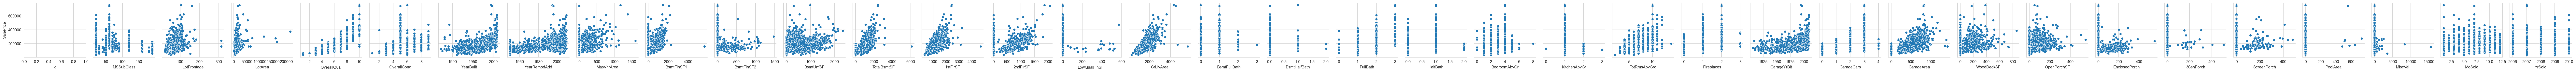

In [315]:
plt.figure(figsize=(100,100))
sns.pairplot(data=house, x_vars=list(house.drop(['SalePrice'],axis=1).select_dtypes(exclude=['object']).columns), y_vars=['SalePrice'])
plt.show()

Based on the above graphs, we can see that the predictors have a somewhat linear relationship with the target. 

Next, let's look at the distribution of each of our variables (refer to histograms and boxplots of our variables)

In [316]:
house.hist(bins=30, figsize=(100, 100))
plt.show()

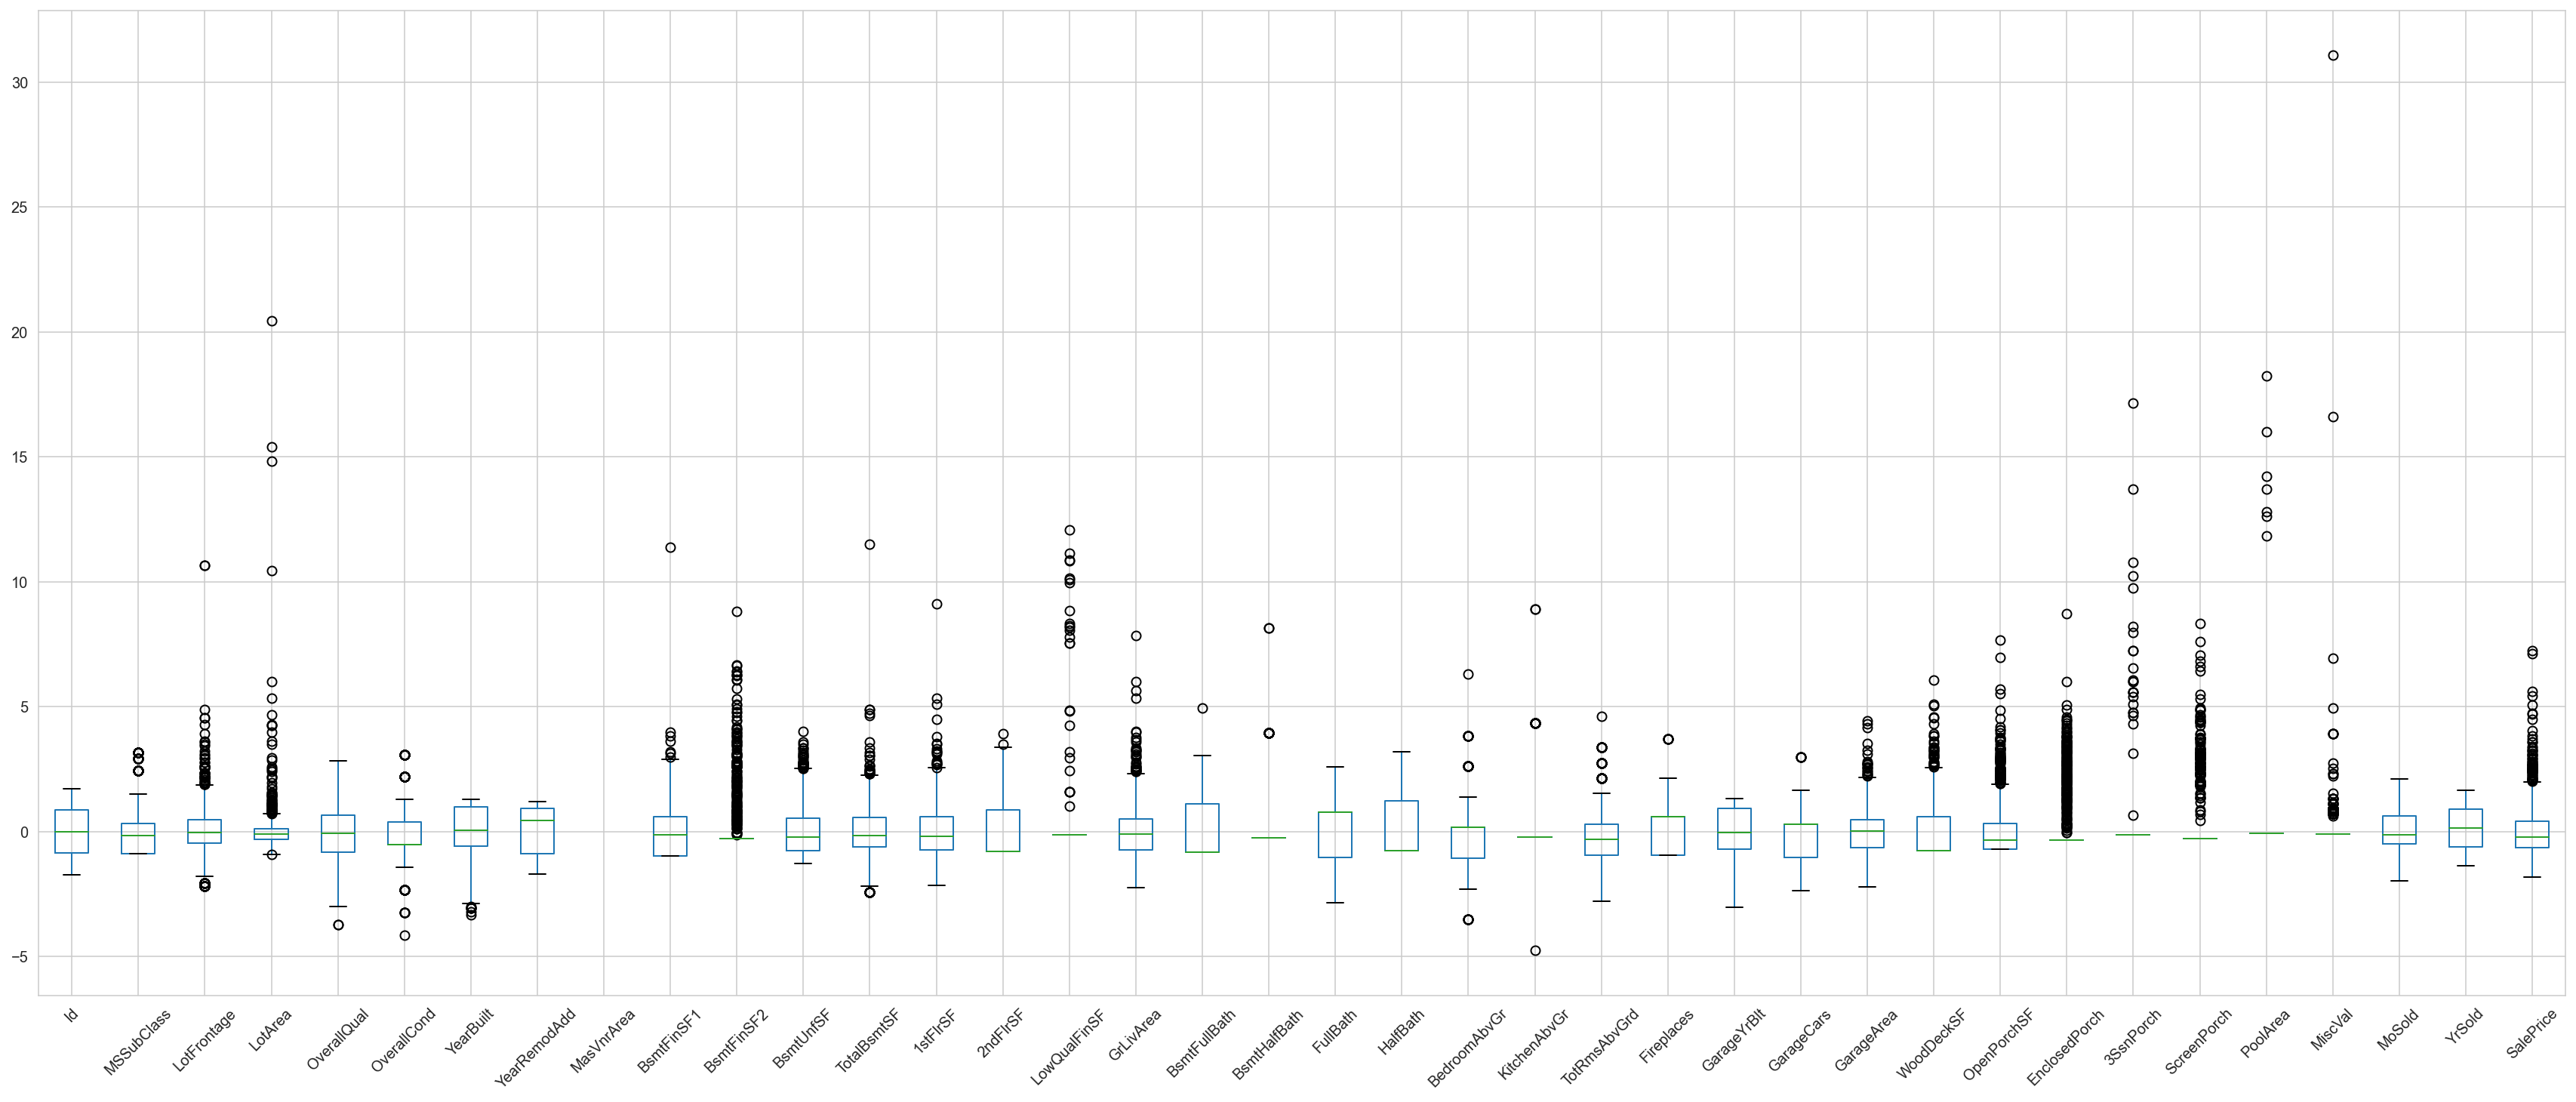

In [317]:
from scipy.stats import zscore
n_house=impute_GarageYrBlt(impute_LotFrontage(house)).select_dtypes(include=['float64', 'int64']).apply(zscore)

n_house.plot(kind='box', figsize=(30,12), rot=45)
plt.show()

The above box plot shows that the dataset is messy with multiple columns with outliers. As part of this study, I want to take a look at how the models perform with data with outliers so I will keep these outliers for now. 
Next, we'll also look at the correlation of our variables through a heatmap. 

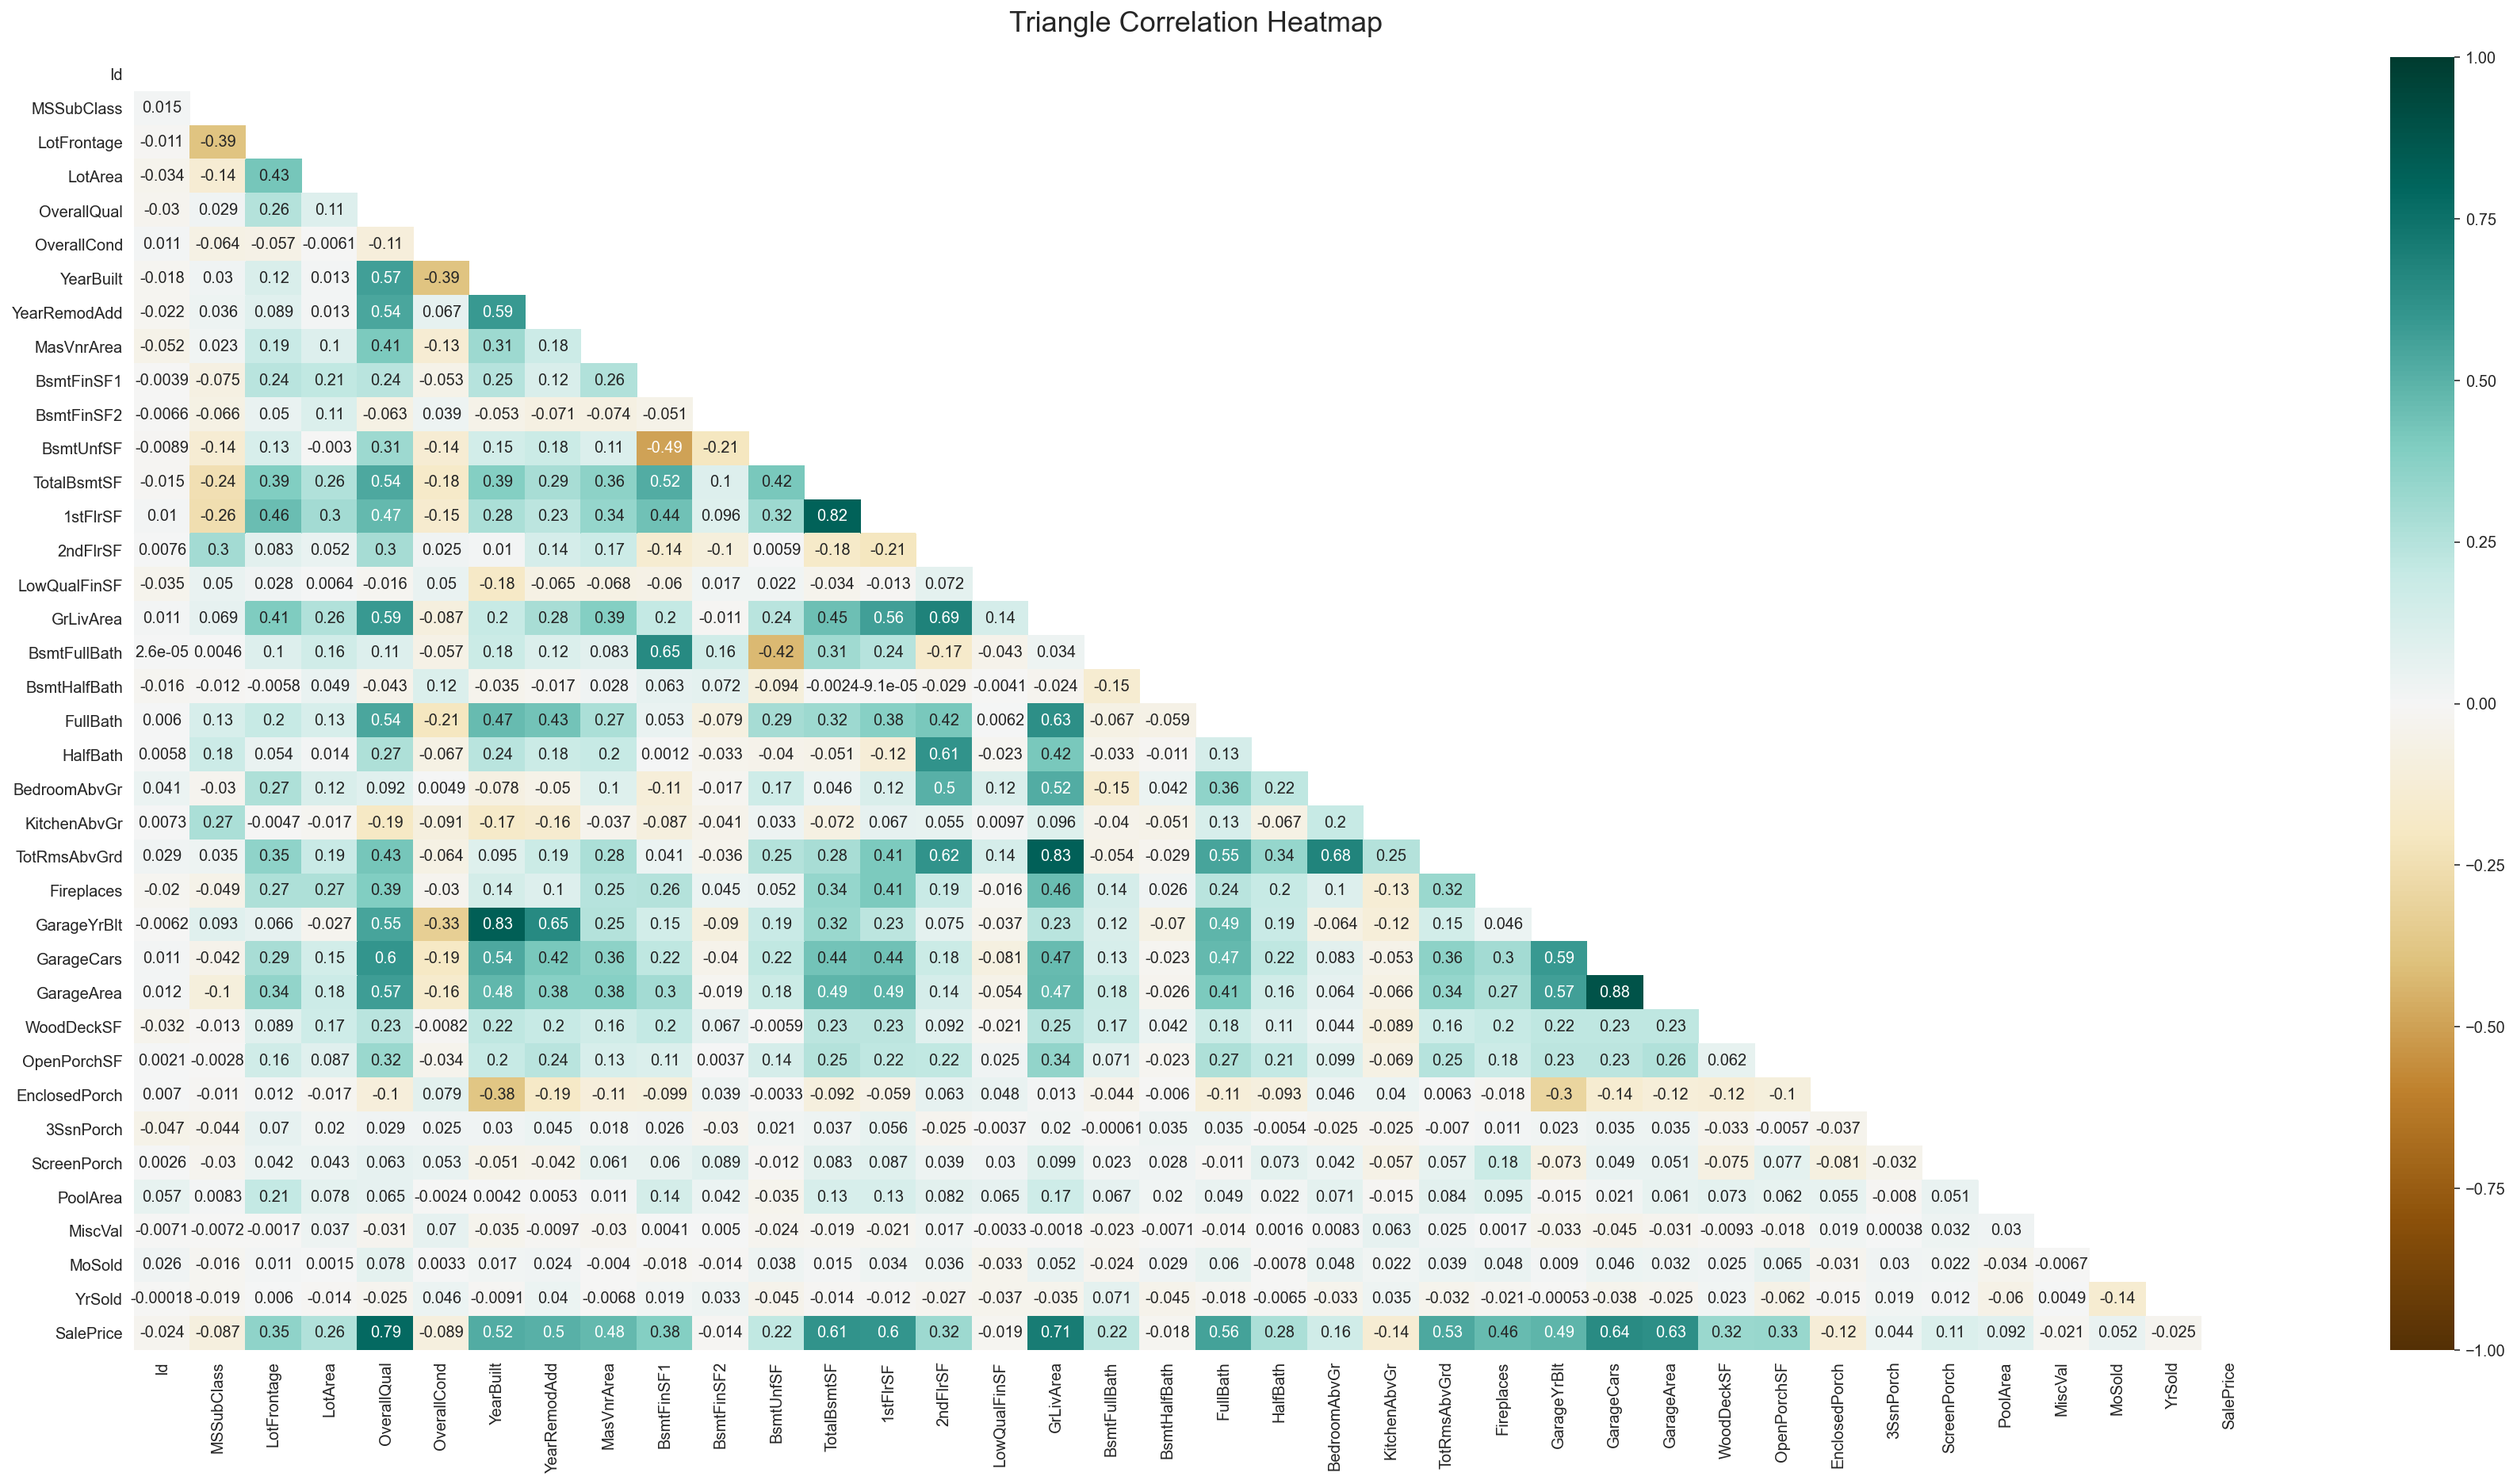

In [318]:
plt.figure(figsize=(30, 15))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(house.corr(), dtype=np.bool))
heatmap = sns.heatmap(house.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

The above heatmap shows that many of our variables are correlated. Multicollinearity could be an issue if we were to use Simple Linear Regression as it violates the LINE rule. We'll take a look later by comparing a simple linear regression with regularized regression models using Lasso and Ridge. The regularised models will help address the multicollinearity issue. 

Moving on to cleaning our variables,  we'll change the int/float variables that should be treated as categorical into object/string so that we can dummy the variables.

In [319]:
#categorical variables that are type int/float in the original df
house['OverallQual']=house['OverallQual'].astype(str)
house['OverallCond']=house['OverallCond'].astype(str)
house['MSSubClass']=house['MSSubClass'].astype(str)


Next we look at the null values in our df. 

In [320]:
get_nulls(house)

nulls
LotFrontage     259
Alley          1361
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     681
GarageType       79
GarageYrBlt      79
GarageFinish     79
GarageQual       79
GarageCond       79
PoolQC         1443
Fence          1172
MiscFeature    1398

For most of the variables, the NA input corresponds to a valid data translating to the lack of that particular feature in the house(i.e. NA in Alley means 'No Alley Access'). However, below are the 3 rows where NA is not a valid input. Since these are only 3 rows, I decided to drop these rows as it will not affect the dataset.   

In [321]:
#BsmtExposure and BsmtFinType2 both have one more na than the other Basement predictors, 
#upon checking the values for these rows, I have concluded that for these 2 rows, na is not a valid input. 
#hence, I will drop these 2 rows.
house.drop(house.loc[(house.BsmtQual.notna()) & (house.BsmtExposure.isna()),].index, inplace=True)
house.drop(house.loc[(house.BsmtQual.notna()) & (house.BsmtFinType2.isna()),].index, inplace=True)

#na is not a valid input for Electricals. Since this is just 1 row, I will drop this. 
house.drop(house.loc[(house.Electrical.isna()),].index, inplace=True)

In [322]:
#This is NA if there is no MasVnr. Hence, I will change nulls in MasVnrArea to 0. 
house['MasVnrArea'].fillna(value=0, inplace=True)

#Id is just an index so I will drop this
house.drop('Id', axis=1, inplace=True)

#### Some key insights about our predictors

#### - Dataset has outliers (I will not remove this as I want to be able to see how robust our model can be when we have outliers in our training data. 

#### - Most predictors have a somewhat linear relationship with our target. We will look into some type of Linear Regression

#### - Many variables are correlated. This means that a simple Linear Regression will not be a good model. 

### I.3. Target

#### We take a look at our Target


In [323]:
target= house['SalePrice'].copy()

In [324]:
target.isnull().sum()

0

In [325]:
target.describe().to_frame().T

count           mean           std      min       25%       50%  \
SalePrice  1447.0  181586.500346  79211.447986  37900.0  130000.0  163500.0   

                75%       max  
SalePrice  214000.0  755000.0

In [326]:
#additional key stats about our variables

#median
y_median = target.median()
# mode
y_mode = target.mode().values
y_variance= target.var()
y_sem= target.sem()
y_skew= target.skew()
print("median:", y_median, "\n", "mode:", y_mode, '\n',
      "variance:", y_variance, "\n", "sem:", y_sem, "\n", 
      "skew:", y_skew)

median: 163500.0 
 mode: [140000] 
 variance: 6274453492.039929 
 sem: 2082.34980568283 
 skew: 1.9109538823000898


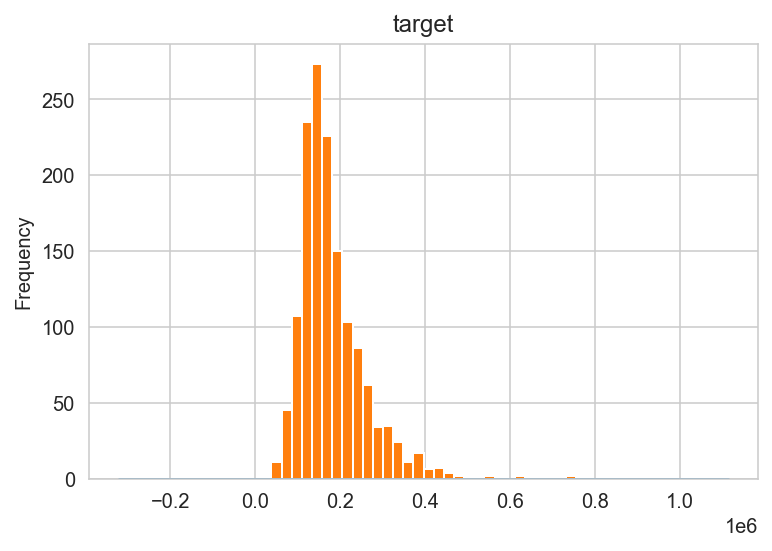

In [327]:
ax= target.plot(kind='kde')
target.plot(kind='hist', bins=30, ax=ax)
ax.set_title('target')
 
plt.show()

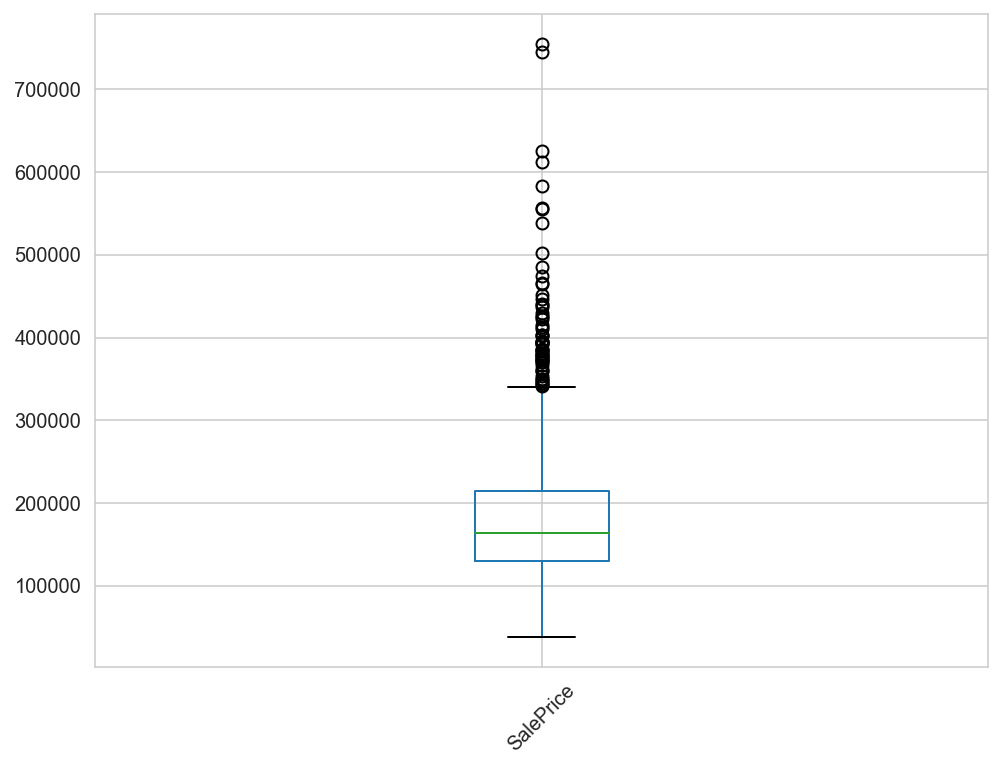

In [328]:
target.plot(kind='box', figsize=(8,6), rot=45)
plt.show()

##### Our target has a number of outliers. Cleaning outliers is not part of our scope so we will keep the outliers. We will also see how this impacts the performance of our models. 

##### Our target variable is highly skewed so we will take the log of our target to be able to normalize the distribution. 

In [329]:
y_log= np.log(target)

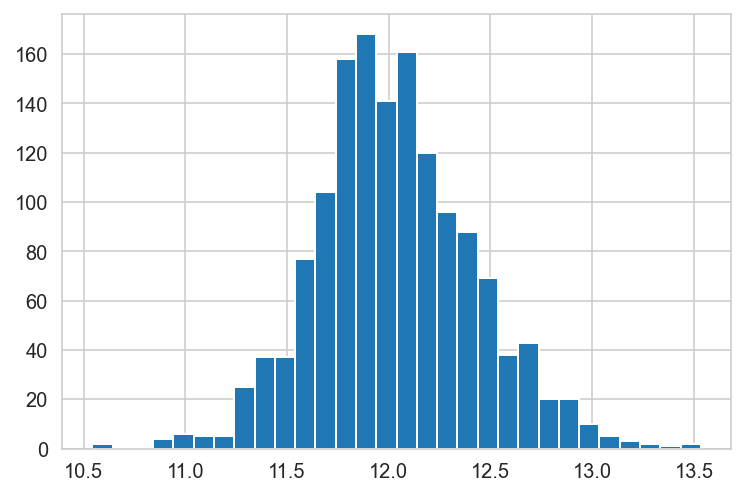

In [330]:
plt.hist(y_log, bins=30) 
plt.show()

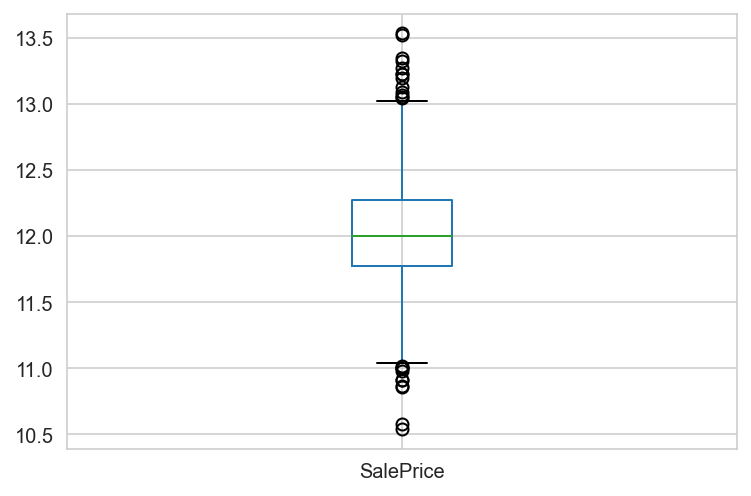

In [331]:
y_log.plot(kind='box')
plt.show()

We now have a relatively normal distribution for our target variable. Next, we slice our target data into our train and test. 

In [332]:
#We separate our train and test data from original df. We take the log of the values to normalise the distribution of our target
y_log_train= np.log(house[house['YrSold']<2010]['SalePrice'].copy())
y_log_test= np.log(house[house['YrSold']>=2010]['SalePrice'].copy())

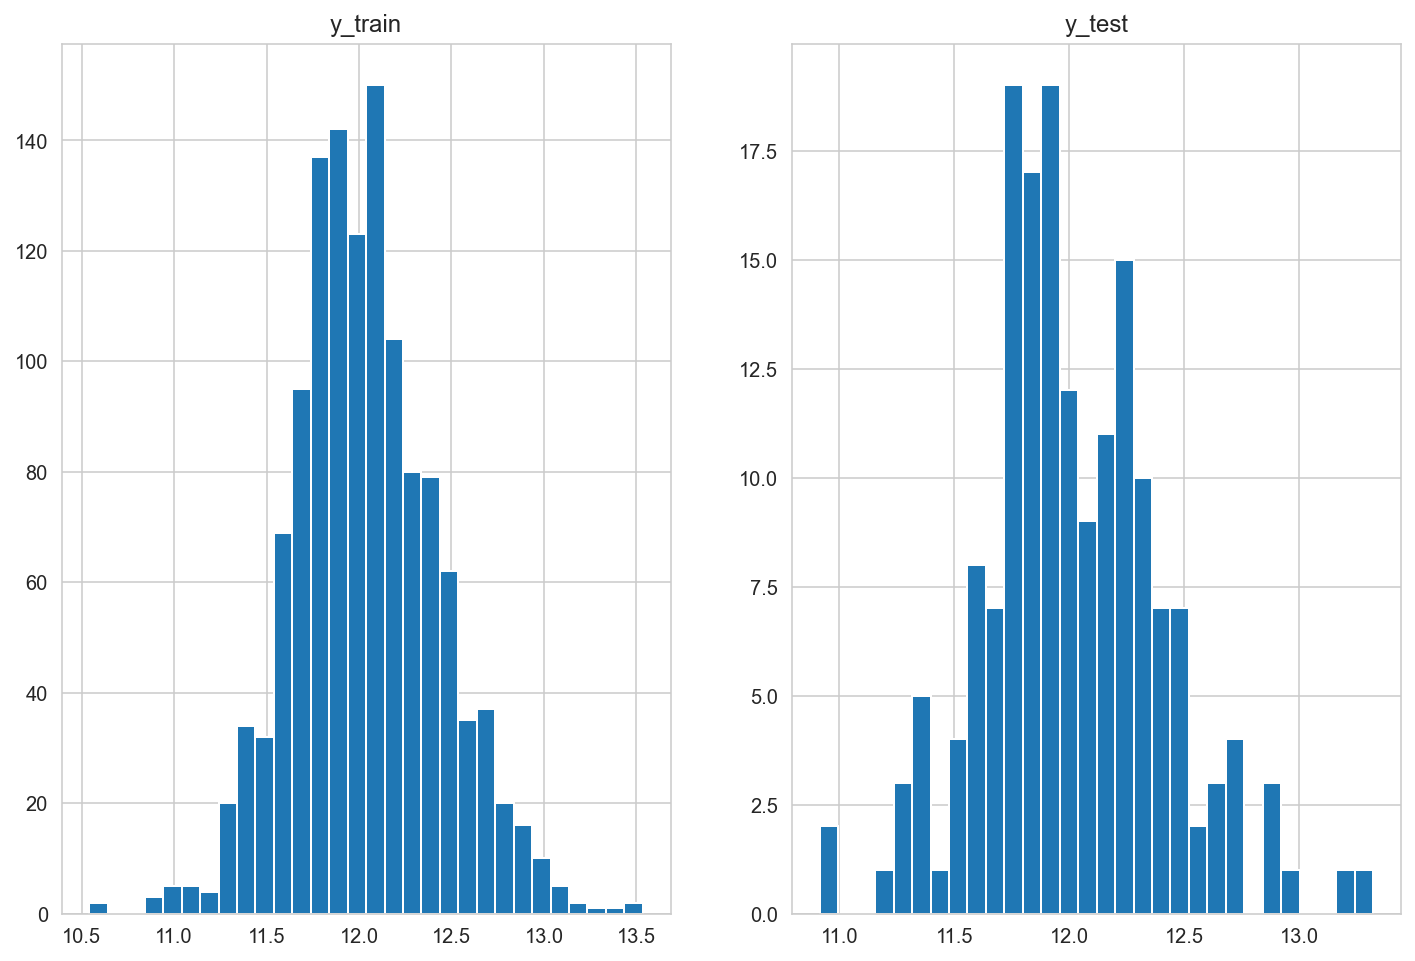

In [333]:
#to confirm if both our y_train and y_test have both become normally distributed after we take the log, we'll plot the histograms below 
fig, axes = plt.subplots(ncols=2, figsize=(12,8))
ax0= y_log_train.hist(bins=30, ax=axes[0])
ax0.set_title('y_train')
ax1= y_log_test.hist(bins=30, ax=axes[1]) 
ax1.set_title('y_test')
plt.show()

#### Some key insights about our target

#### - Target is positively skewed. Taking the log gives our target a more normal distribution.  

#### - No null values

#### - Has a few outliers 

#### - Below are some key statistics of our target variable

median: 163500.0 
mode: [140000] 
variance: 6274453492.039929 
sem: 2082.34980568283 
skew: 1.9109538823000898
count: 1447.0	
mean: 181586.500346	
std: 79211.447986	
min: 37900.0	
25%: 130000.0	
50%: 163500.0	
75%: 214000.0	
max: 755000.0

### II. Preprocessing

##### Impute value for LotFrontage (note, we are only using the pre-2010 data to get the value we will use to impute)
refer to the impute_LotFrontage function for how the imputation is done

In [334]:
#assign the output df from our impute_LotFrontage function into a new df. 
house_imputed_lf= impute_LotFrontage(house)

In [335]:
# print(get_nulls(house_imputed_lf))

#### Impute value for na in GarageYrBlt using mean() for the column. Separated the mean for pre2010(train) and 2010 (test) data

In [336]:
house_imputed=impute_GarageYrBlt(house_imputed_lf)

In [337]:
# print(get_nulls(house_imputed))

##### Split Data into fixed and renovatable

Divide the dataset into Fixed and Renovatable features. I am assuming that the target audience is someone who is flipping the house and is only interested in renovating finishings and not in renovations that would require construction. Hence, I am only considering surface improvements on quality and condition as renovatable. I am considering all floor areas of the house as fixed. 
Below are the renovatable features that I determined:

In [338]:
Renovatable_columns= ['OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                      'ExterQual', 'ExterCond','BsmtQual','BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
                     'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 
                     'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

In [339]:
q1, q2= split_fix_renov(house_imputed, Renovatable_columns)

#### Get dummies

In [340]:
#note, df has null values that should be valid inputs. These values should mean the lack of that particular feature in the house
#my_dummies function considers this and uses na as the reference column
fixed_dummies= my_dummies(q1)

In [341]:
fixed_dummies.shape

(1447, 167)

In [342]:
##Check to make sure we do not haver any nulls

# print(get_nulls(fixed_dummies))

#### Low Variance Threshold
Variables with very low variance are dropped. 

In [343]:
X= low_var_threshold(fixed_dummies, fixed_dummies, 0.001)

The following columns were dropped because there is very small variance in its values: ['MiscFeature_TenC', 'Utilities_NoSeWa', 'Condition2_PosA', 'Condition2_RRAe', 'Condition2_RRAn', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Functional_Sev']


In [344]:
X.shape

(1447, 158)

#### Split Data into Train and Test

In [345]:
X_train, X_test= train_test_X(X)

In [346]:
# X_train.head()

#### StandardScale

In [347]:
def my_scaler(df_train, df_test):
    df_scaler= StandardScaler()
    scaled_train= df_scaler.fit_transform(df_train)
    scaled_test= df_scaler.transform(df_test)
    return scaled_train, scaled_test, df_scaler

### III. TASK 1: Predict SalesPrice based on fixed variables 

In [348]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [349]:
# y_train= house[house['YrSold']<2010]['SalePrice'].values
y_train= y_log_train
y_test= y_log_test

In [350]:
Xss_train, Xss_test, ss = my_scaler(X_train, X_test)

#### As mentioned earlier, the predictors have a somewhat linear relationship with the target. Our target is a continuous figure. Hence, we will look at regression models. We will be looking at and comparing the following models.
1. Simple Linear Regression
2. Ridge
3. Lasso
4. Stochastic Gradient Descent
5. Support Vector Regression

Note that a summary discussion follows below after all the models are shown.

In [351]:
#Below are functions created for modelling in order to streamline the process. 

In [352]:
#create a dataframe for the coefs from the models. Function returns a dataframe
def get_model_coefs(var_names, coefs_list, sort_by):
    output = pd.DataFrame({'variable':var_names,
                            'coef':coefs_list,
                            'abs_coef':np.abs(coefs_list)})
    output.sort_values(sort_by, inplace=True, ascending=False)
    return output

In [353]:
#create plots for the residuals for both train and test data.
def plot_residuals(y_hat_train, resi_train, y_hat_test, resi_test, model_type=""):
    title= model_type +' Model Residual Plots for Train and Test Data'
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
    fig.suptitle(title)
    axes[0,0].scatter(x= y_hat_train, y=resi_train)
    axes[0,1].hist(x=resi_train, bins=10)
    axes[1,0].scatter(x= y_hat_test, y=resi_test, color='g')
    axes[1,1].hist(x=resi_test, bins=10, color='g')
    plt.show()

In [354]:
#below function does the following:
#initialise the model based on model type chosen
#fit the train dataset
#cross val and score training data
#transform and score testing data 
#compute residuals
#get coefs and change it into df
#plot the residuals. 


from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from math import sqrt
import warnings
warnings.filterwarnings('ignore')

def model_func(model_type, X_train,y_train, X_test, y_test, var_names, sort_by):
    
    #below variable will be used to check if kernel is a sigmoid in SVR type 
    sigmoid=False
    poly=False
    
    #initialise the model based on what input model_type is
    if model_type=="SGD Regression":
        #below are gridsearch hyperparameters to tune the model
        sgd_params = {
            'loss':['squared_loss','huber'],
            'penalty':['l1','l2', 'elasticnet'],
            'alpha':np.logspace(-5,1,25)
        }
        
        
        sgd_reg = SGDRegressor()
        
        model = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=False)
        model.fit(X_train, y_train)
        print("SGD best params:", model.best_params_)
        print("SGD best score:", model.best_score_)
        print("SGD best estimator:", model.best_estimator_)
        best_model = model.best_estimator_
    
    #simple linear regression
    elif model_type=='Linear Regression':
        model= LinearRegression()
        best_model= LinearRegression()
    
    #Ridge model
    elif model_type=='Ridge':
        ridge_alphas = np.logspace(0, 5, 200)
        model= RidgeCV(alphas=ridge_alphas, cv=10)
        model.fit(X_train, y_train)
        best_model= Ridge(alpha=model.alpha_)
    
    #Lasso Model
    elif model_type=='Lasso':
        model= LassoCV(n_alphas=500, cv=10, verbose=0)
        model.fit(X_train, y_train)
        best_model= Lasso(alpha=model.alpha_)
    
    #Support Vector Regression
    elif model_type=='SVR':
        #hyperparameter range for tuning
        svr_params = {
            'gamma':np.logspace(-5,9, 5),
            'epsilon':np.logspace(0,0.5, 10 ),
            'C':np.logspace(-3, 8, 10),
            'kernel':['linear','rbf', 'poly', 'sigmoid']
        }
        
        svr_reg=SVR()
        
        model = GridSearchCV(svr_reg, svr_params, cv=5, verbose=1, n_jobs=-1)
        model.fit(X_train, y_train)
        print("SVR best params:", model.best_params_)
        print("SVR best score:", model.best_score_)
        print("SVR best estimator:", model.best_estimator_)
        best_model = model.best_estimator_
        
        if model.best_params_['kernel']=='sigmoid':
            sigmoid=True
        elif model.best_params_['kernel']=='poly':
            poly=True

    #crossval the chosen model with 10 folds
    model_scores = cross_val_score(best_model, X_train, y_train, cv=10)

    #get mean of the cross val scores to get the model score
    cv_score=np.mean(model_scores)
    #get var of the cross val scores
    cv_score_var= np.var(model_scores)
    
    #fit the train data in the best_model
    best_model.fit(X_train,y_train)
    
    #get scores for our train and test data
    train_score=best_model.score(X_train,y_train)
    test_score=best_model.score(X_test,y_test)
    
    #compute the residuals for our train and test set
    yhat_train=best_model.predict(X_train)
    yhat_test=best_model.predict(X_test)
    
    rms_train = sqrt(mean_squared_error(y_train, yhat_train))
    rms_test = sqrt(mean_squared_error(y_test, yhat_test))

    
    residual_train=y_train - yhat_train
    residual_test=y_test- yhat_test
    
    #if SVR model is chosen and best model kernel is a sigmoid, there will be no coefs.
    #below will catch this error. 
    
    
    if sigmoid:
        model_coefs='no coefs. model uses a sigmoid kernel. coef is only available when using a linear kernel'
    #if SVR kernel is poly, it will output the coef array
    elif poly:
        model_coefs=pd.Dataframe(best_model.coef_)
        model_coefs['variable']=var_names
    
    else:
        #if coefs is multidimensional, we create a dataframe of the coefs
        if best_model.coef_.ndim>1:
            print('model coefs is multidimensional')
            model_coefs=pd.DataFrame(best_model.coef_)

        #if model is linear with only one set of coefs, we will use the get_model_coefs function
        #output will be a dataframe of coefficients
        else:
            model_coefs = get_model_coefs(var_names, best_model.coef_, sort_by)

    print(" cv score is:", cv_score,"\n", 
          "cv score variance is:", cv_score_var, "\n", 
          "model score on training data is:", train_score, "\n",
          "RMSE on training data is:",rms_train, "\n",
          "model score on testing data is:", test_score, "\n",          "RMSE on testing data is:",rms_test, "\n",
          "RMSE on testing data is:",rms_test, "\n",
          "residual mean:", np.mean(residual_train))
    
    #record the performance of the model to output
    results={}
    results['cv_score']= cv_score
    results['cv_score_variance']=cv_score_var
    results['score_on_train']= train_score
    results['RMSE_train']= rms_train
    results['score_on_test']= test_score
    results['RMSE_test']=rms_test
    results['residual_mean_train']= np.mean(residual_train)
    results['residual_mean_test']=np.mean(residual_test)
    results['yhat_train_mean']=np.mean(yhat_train)
    results['yhat_test_mean']=np.mean(yhat_test)

    #plot the residuals (histgroam and scatter) using my plot_residuals function. 
    plot_residuals(yhat_train, residual_train, yhat_test, residual_test, model_type)

    
    return model_coefs, results, residual_train, residual_test

#### III. 0. Baseline

In [355]:
print(y_train.mean())
print(y_train.sem())
print(y_test.mean())
print(y_test.sem())

12.031840936391179
0.01096858715430383
12.01500704811807
0.030105753956137606


#### III. 1. Simple Linear Regression

 cv score is: -8.66847720232911e+21 
 cv score variance is: 6.569394470306029e+44 
 model score on training data is: 0.9029125177461472 
 RMSE on training data is: 0.12198797548531604 
 model score on testing data is: 0.8759003672605425 
 RMSE on testing data is: 0.13868606033329015 
 RMSE on testing data is: 0.13868606033329015 
 residual mean: 3.4733787897109513e-07


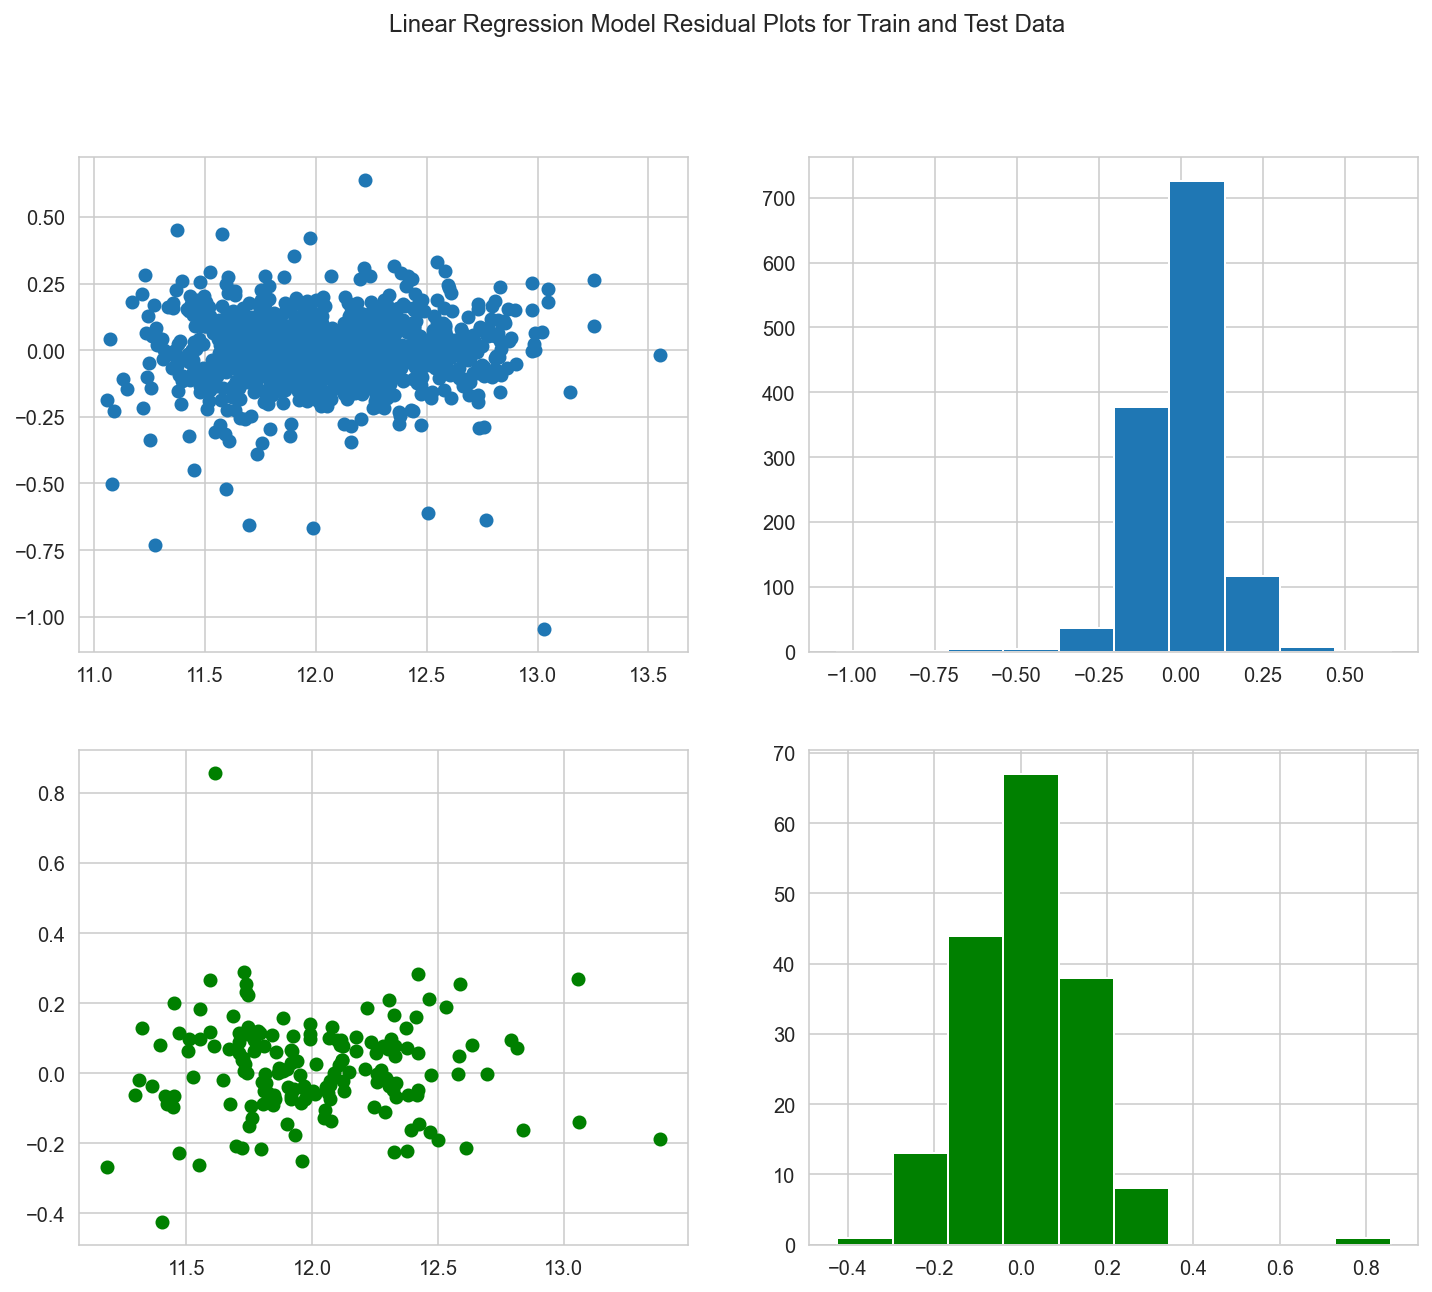

variable          coef      abs_coef
5          BsmtFinSF1 -5.885864e+10  5.885864e+10
7           BsmtUnfSF -5.717135e+10  5.717135e+10
8         TotalBsmtSF  5.619689e+10  5.619689e+10
6          BsmtFinSF2 -1.991354e+10  1.991354e+10
60      MSSubClass_90  3.438906e+09  3.438906e+09
114   BldgType_Duplex -3.438906e+09  3.438906e+09
124   RoofStyle_Gable -1.877470e-01  1.877470e-01
126     RoofStyle_Hip -1.695142e-01  1.695142e-01
11          GrLivArea  1.394882e-01  1.394882e-01
129  RoofMatl_CompShg  7.123947e-02  7.123947e-02

In [356]:
lr_coefs, lr_results, lr_residual_train, lr_residual_test= model_func('Linear Regression', Xss_train,y_train,Xss_test, y_test, X_train.columns, 'abs_coef')
lr_coefs.head(10)

In [357]:
lr_results

{'cv_score': -8.66847720232911e+21,
 'cv_score_variance': 6.569394470306029e+44,
 'score_on_train': 0.9029125177461472,
 'RMSE_train': 0.12198797548531604,
 'score_on_test': 0.8759003672605425,
 'RMSE_test': 0.13868606033329015,
 'residual_mean_train': 3.4733787897109513e-07,
 'residual_mean_test': 0.01336949647826448,
 'yhat_train_mean': 12.031840589053301,
 'yhat_test_mean': 12.001637551639805}

#### III. 2. Ridge

 cv score is: 0.8346614197786055 
 cv score variance is: 0.006945297012442561 
 model score on training data is: 0.8822369974767815 
 RMSE on training data is: 0.13435067088525687 
 model score on testing data is: 0.8962038950810118 
 RMSE on testing data is: 0.12683470155874293 
 RMSE on testing data is: 0.12683470155874293 
 residual mean: -3.552713678800501e-16


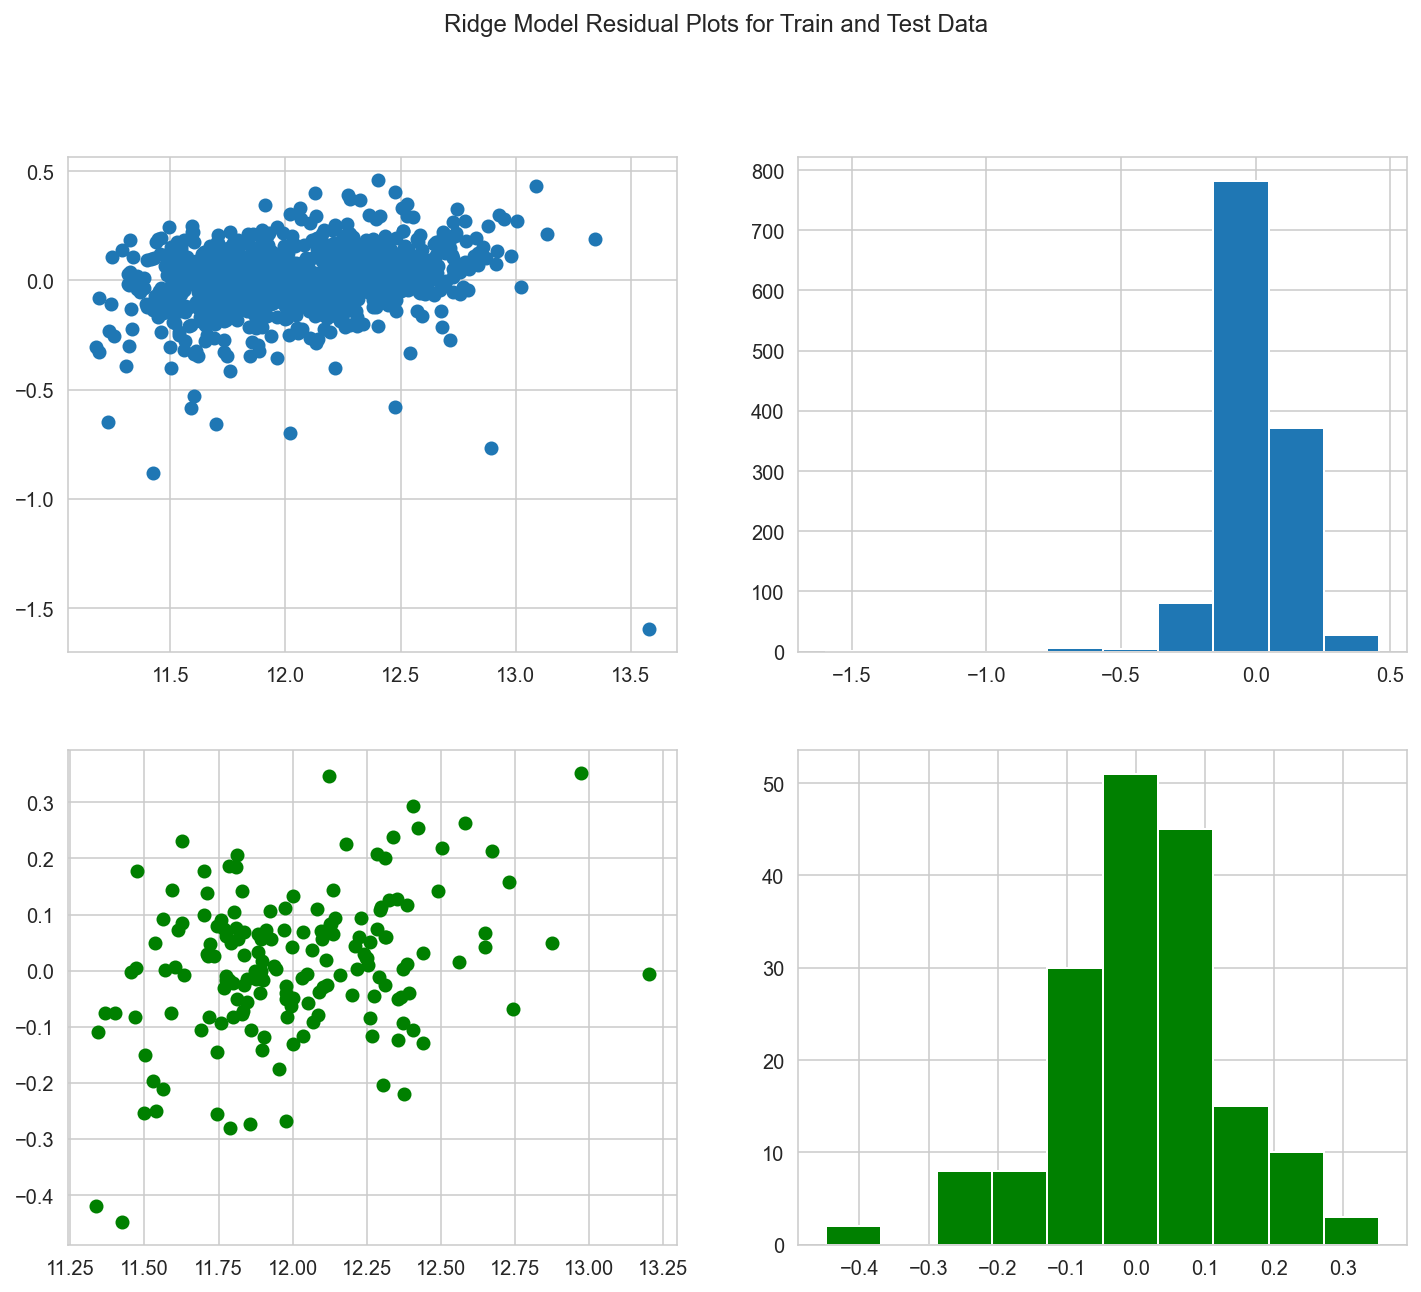

variable      coef  abs_coef
11             GrLivArea  0.039005  0.039005
3           YearRemodAdd  0.037153  0.037153
21            GarageCars  0.032775  0.032775
9               1stFlrSF  0.028931  0.028931
19            Fireplaces  0.027628  0.027628
92  Neighborhood_NridgHt  0.027067  0.027067
14              FullBath  0.026922  0.026922
22            GarageArea  0.025968  0.025968
18          TotRmsAbvGrd  0.024585  0.024585
8            TotalBsmtSF  0.023548  0.023548

In [358]:
Ridge_coefs, Ridge_results, Ridge_residual_train, Ridge_residual_test= model_func('Ridge', Xss_train,y_train,Xss_test, y_test, X_train.columns, 'abs_coef')
Ridge_coefs.head(10)

In [359]:
Ridge_results

{'cv_score': 0.8346614197786055,
 'cv_score_variance': 0.006945297012442561,
 'score_on_train': 0.8822369974767815,
 'RMSE_train': 0.13435067088525687,
 'score_on_test': 0.8962038950810118,
 'RMSE_test': 0.12683470155874293,
 'residual_mean_train': -3.552713678800501e-16,
 'residual_mean_test': 0.009589626997032771,
 'yhat_train_mean': 12.03184093639118,
 'yhat_test_mean': 12.005417421121036}

#### III.3. Lasso

 cv score is: 0.8267451784257119 
 cv score variance is: 0.013666341122699727 
 model score on training data is: 0.8837571707252296 
 RMSE on training data is: 0.13348070455868702 
 model score on testing data is: 0.9048208494655519 
 RMSE on testing data is: 0.1214558605340381 
 RMSE on testing data is: 0.1214558605340381 
 residual mean: -3.496984836780101e-16


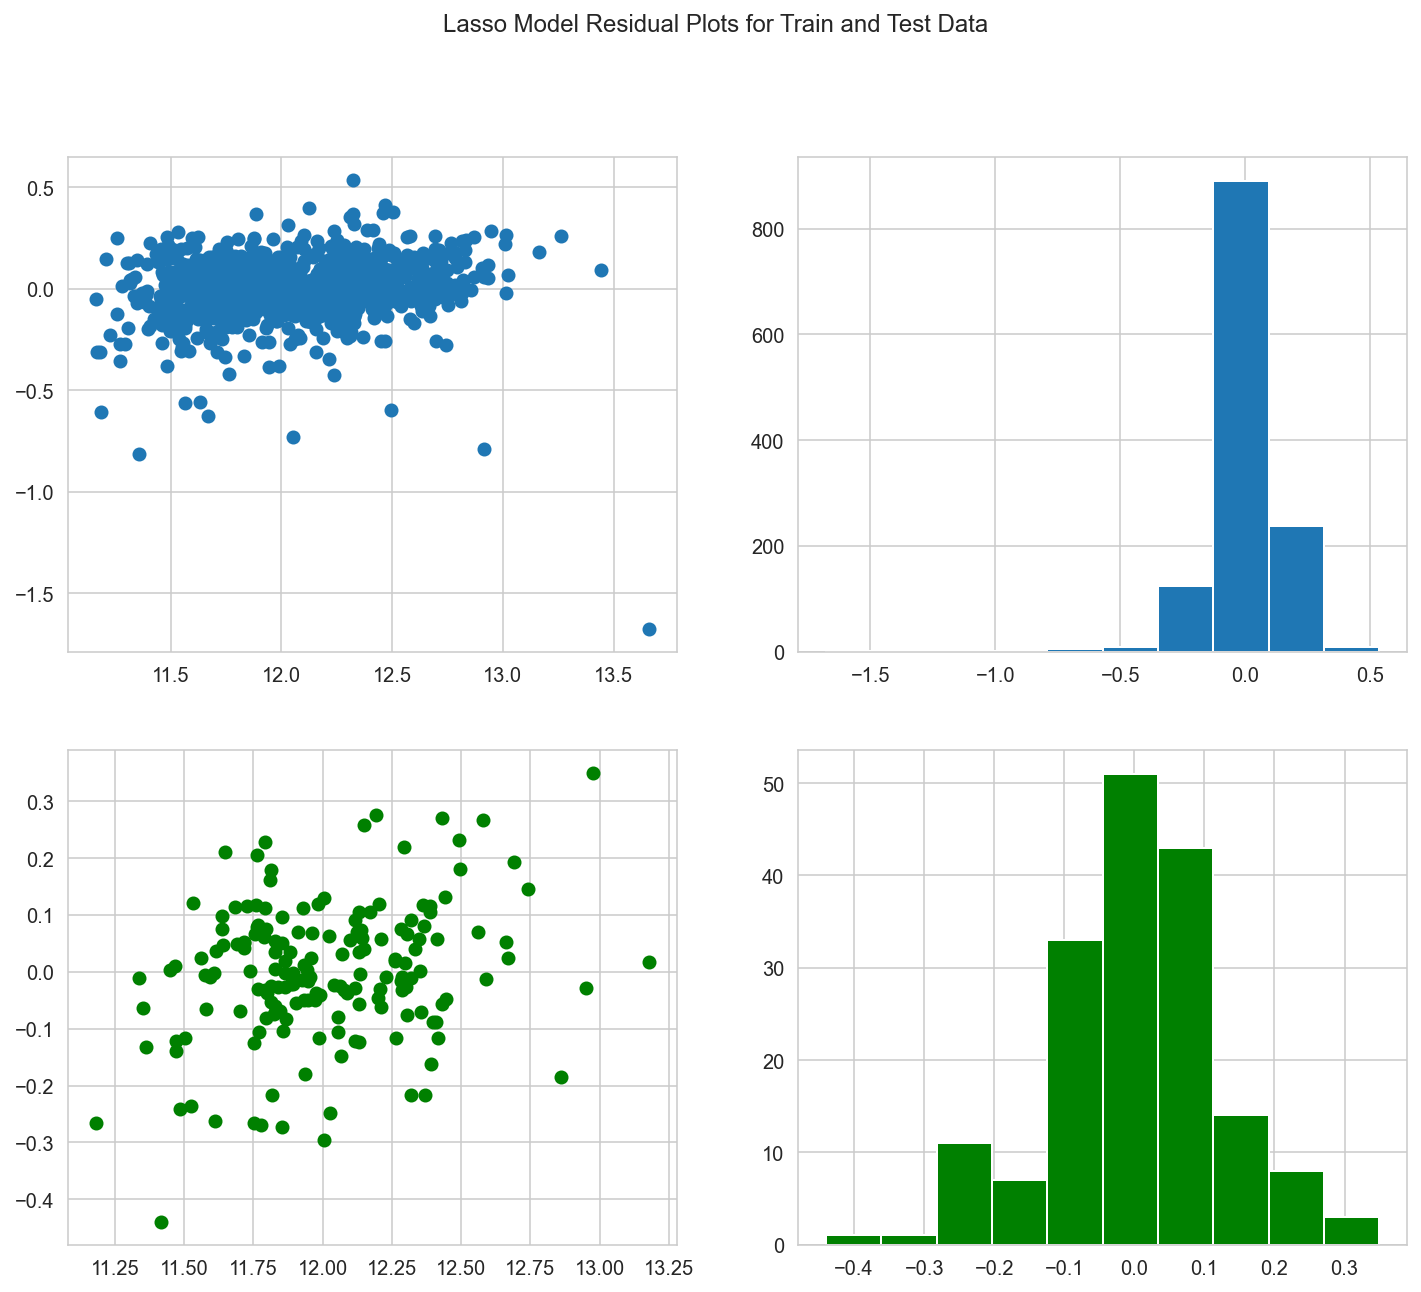

variable      coef  abs_coef
11             GrLivArea  0.131644  0.131644
21            GarageCars  0.054435  0.054435
3           YearRemodAdd  0.053990  0.053990
92  Neighborhood_NridgHt  0.036932  0.036932
2              YearBuilt  0.033427  0.033427
19            Fireplaces  0.031217  0.031217
17          KitchenAbvGr -0.024524  0.024524
82  Neighborhood_Crawfor  0.024372  0.024372
12          BsmtFullBath  0.024086  0.024086
98  Neighborhood_StoneBr  0.022665  0.022665

In [360]:
lasso_df, lasso_results, lasso_residual_train, lasso_residual_test= model_func('Lasso', Xss_train,y_train, Xss_test, y_log_test, X_train.columns, 'abs_coef')
lasso_df.head(10)

In [361]:
lasso_results

{'cv_score': 0.8267451784257119,
 'cv_score_variance': 0.013666341122699727,
 'score_on_train': 0.8837571707252296,
 'RMSE_train': 0.13348070455868702,
 'score_on_test': 0.9048208494655519,
 'RMSE_test': 0.1214558605340381,
 'residual_mean_train': -3.496984836780101e-16,
 'residual_mean_test': -0.0008548386609375268,
 'yhat_train_mean': 12.031840936391179,
 'yhat_test_mean': 12.015861886779005}

#### III.4. Stochastic Gradient Descent

SGD best params: {'alpha': 0.31622776601683794, 'loss': 'huber', 'penalty': 'l2'}
SGD best score: 0.8392018139172392
SGD best estimator: SGDRegressor(alpha=0.31622776601683794, loss='huber')
 cv score is: 0.8397905144529438 
 cv score variance is: 0.007391973157900199 
 model score on training data is: 0.8648683618530093 
 RMSE on training data is: 0.14391760569768888 
 model score on testing data is: 0.8930383111306219 
 RMSE on testing data is: 0.12875428425773025 
 RMSE on testing data is: 0.12875428425773025 
 residual mean: -0.0007017456007809288


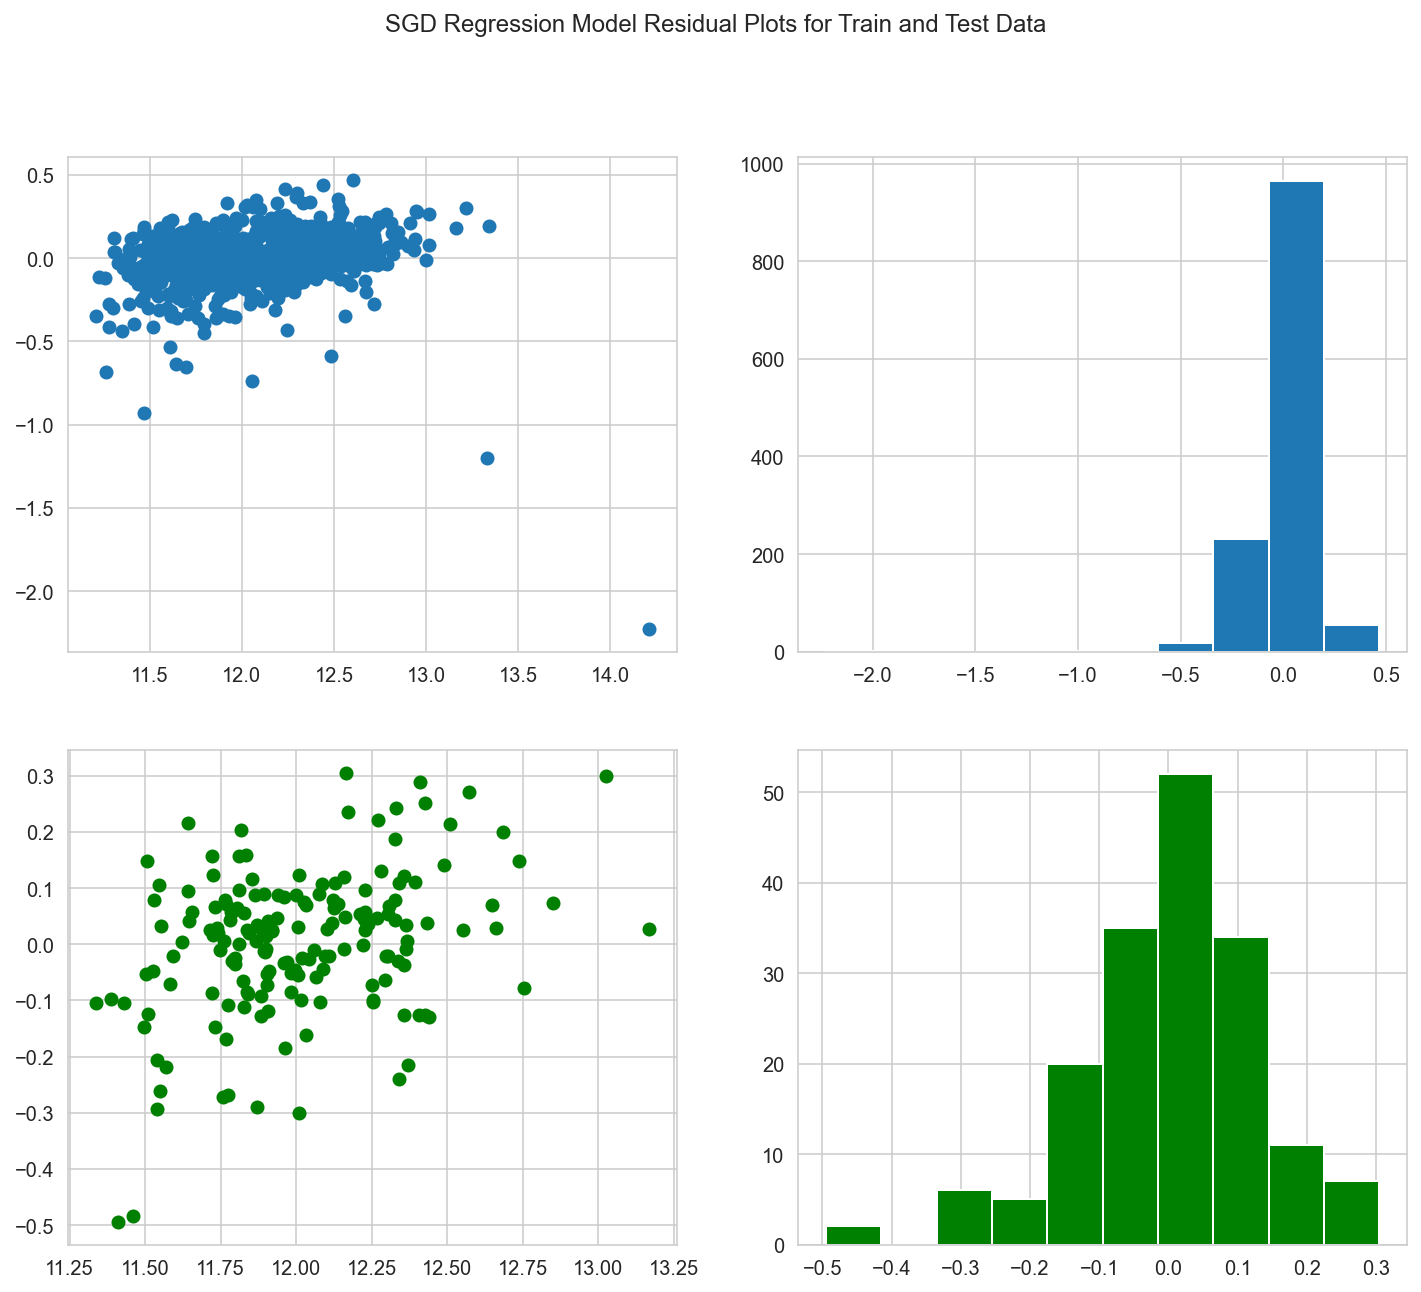

variable      coef  abs_coef
11     GrLivArea  0.040042  0.040042
3   YearRemodAdd  0.033946  0.033946
9       1stFlrSF  0.033515  0.033515
8    TotalBsmtSF  0.033219  0.033219
22    GarageArea  0.026149  0.026149
19    Fireplaces  0.024999  0.024999
5     BsmtFinSF1  0.024638  0.024638
21    GarageCars  0.024105  0.024105
18  TotRmsAbvGrd  0.023069  0.023069
14      FullBath  0.022906  0.022906

In [362]:
sgd_df, sgd_results, sgd_residual_train, sgd_residual_test= model_func('SGD Regression', Xss_train,y_train, Xss_test, y_log_test, X_train.columns, 'abs_coef')
sgd_df.head(10)

In [363]:
sgd_results

{'cv_score': 0.8397905144529438,
 'cv_score_variance': 0.007391973157900199,
 'score_on_train': 0.8648683618530093,
 'RMSE_train': 0.14391760569768888,
 'score_on_test': 0.8930383111306219,
 'RMSE_test': 0.12875428425773025,
 'residual_mean_train': -0.0007017456007809288,
 'residual_mean_test': 0.0034389331634805346,
 'yhat_train_mean': 12.032542681991961,
 'yhat_test_mean': 12.011568114954587}

#### III.5. Support Vector Regression

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   10.2s finished


SVR best params: {'C': 0.2782559402207126, 'epsilon': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
SVR best score: 0.6936766053805256
SVR best estimator: SVR(C=0.2782559402207126, epsilon=1.0, gamma=0.03162277660168379,
    kernel='sigmoid')
 cv score is: 0.7028699984763577 
 cv score variance is: 0.0018258238755355365 
 model score on training data is: 0.7059187378334817 
 RMSE on training data is: 0.2123093307109047 
 model score on testing data is: 0.7215040115606564 
 RMSE on testing data is: 0.20775765518673317 
 RMSE on testing data is: 0.20775765518673317 
 residual mean: 0.017058101858929583


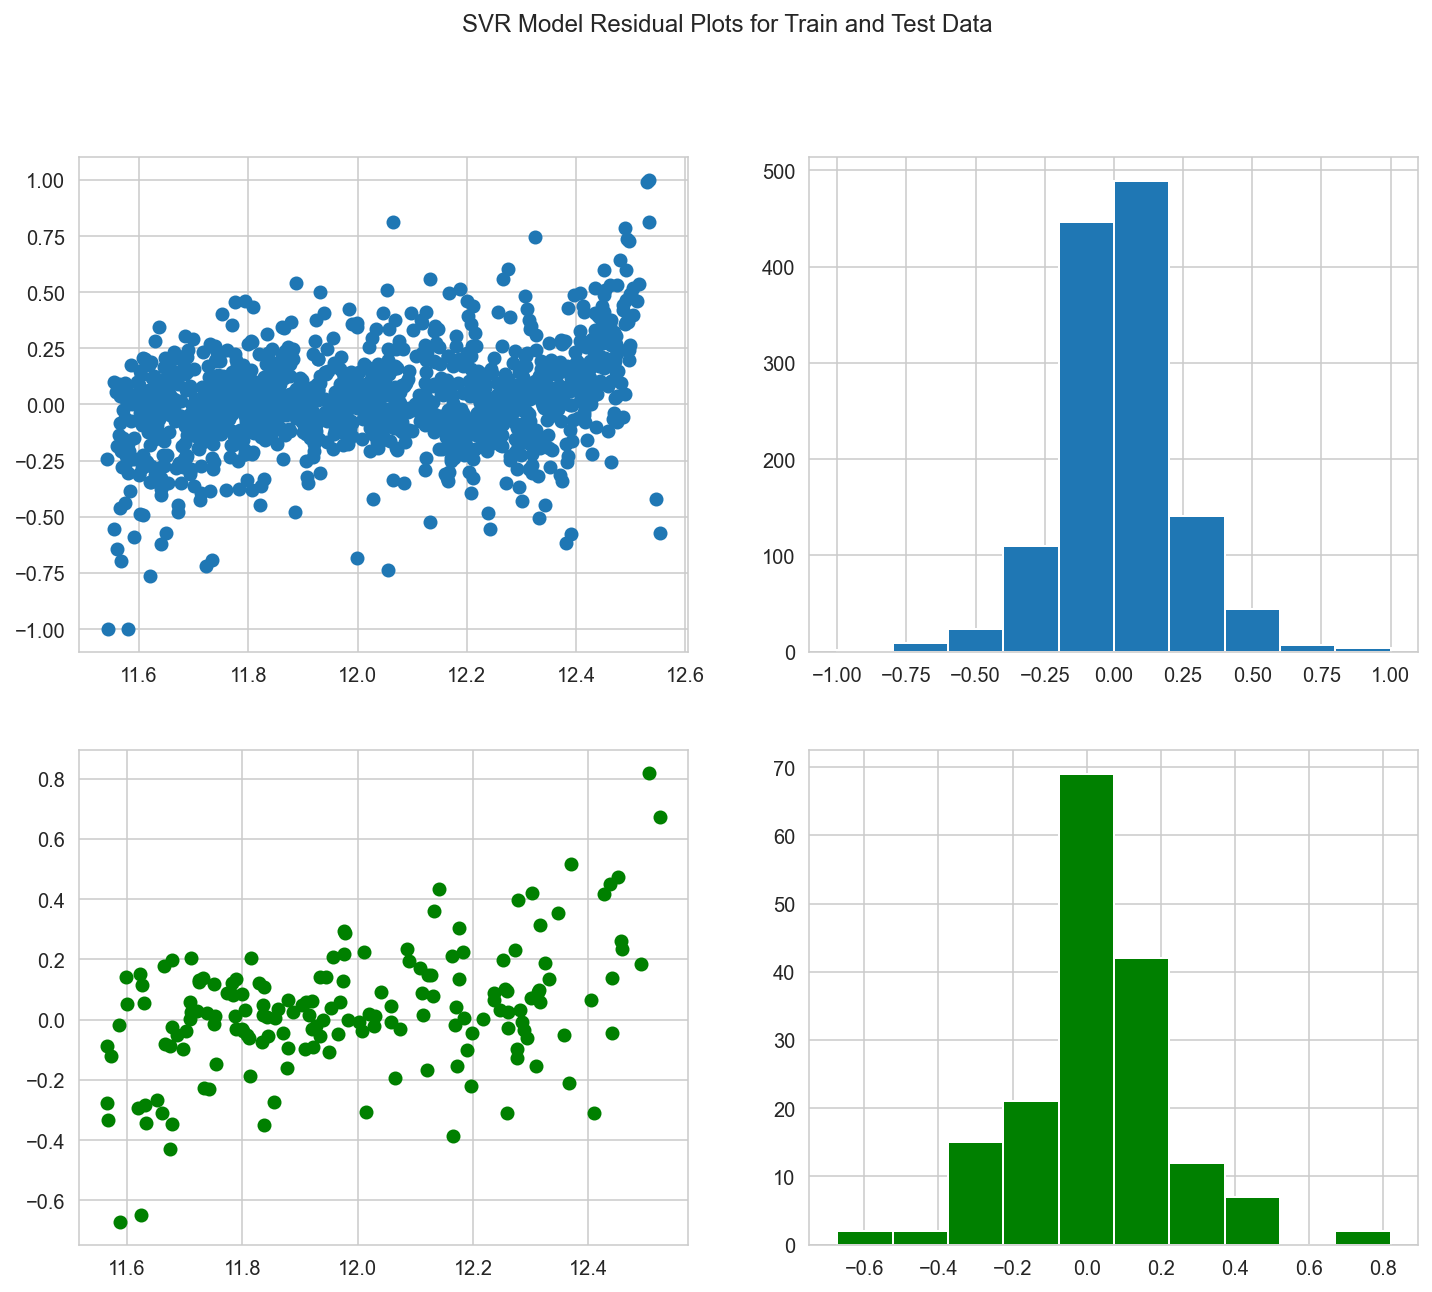

In [364]:
svr_df, svr_results, svr_residual_train, svr_residual_test= model_func('SVR', Xss_train,y_train, Xss_test, y_log_test, X_train.columns, 'abs_coef')


In [365]:
svr_results

{'cv_score': 0.7028699984763577,
 'cv_score_variance': 0.0018258238755355365,
 'score_on_train': 0.7059187378334817,
 'RMSE_train': 0.2123093307109047,
 'score_on_test': 0.7215040115606564,
 'RMSE_test': 0.20775765518673317,
 'residual_mean_train': 0.017058101858929583,
 'residual_mean_test': 0.026561810636965683,
 'yhat_train_mean': 12.014782834532252,
 'yhat_test_mean': 11.9884452374811}

In [366]:
svr_df

'no coefs. model uses a sigmoid kernel. coef is only available when using a linear kernel'

#### SUMMARY OF RESULTS
Below is a summary of performance of our models. Comparing the performance of the models, we can see that the Ridge, Lasso, ans SGDR models performed better than the other two. We can also see that the three abovementioned models' performance are relatively close. I am choosing Lasso as the final model because ot performs at par with the other two, has the lowest RMSE (though difference from Ridge is not that significant), and gives the lowest residuals mean for both train and test data. On top of that, Lasso will be able to reduce the number of variables used in the model, simplifying the interpretation.

Also interesting to note is the extremely negative score we are getting from LR model for cross validated score while we are getting really high score if we only score our test data. This is a clear indication of our model not able to perform well most likely due to the issue of multicollineairty in our predictors. 

Lasso was able to half the number of coefficients used in the model down to 72.

As we are using the log of SalePrice, the coefficients indicate the percentage increase in SalePrice for every standard deviation increase in the predictor. 

Intrepreting the result, we can see below that the abive ground living area GrLivArea has the most impact on our target. The next most impactful variable's impact is only half of the 1st. The number of cars you can park in the garage is another important factor that determines the price of property in Ames. A few neighbourhoods showed to have impact on pricing with North Ridge Heights having the most positive impact- being in the area gives properties a 3.6 percent increase in SalePrice.

In [367]:
summary={}
summary['LR']= lr_results
summary['Ridge']=Ridge_results
summary['Lasso']=lasso_results
summary['SGDR']=sgd_results
summary['SVR']=svr_results
summary=pd.DataFrame(summary).T
summary

cv_score  cv_score_variance  score_on_train  RMSE_train  \
LR    -8.668477e+21       6.569394e+44        0.902913    0.121988   
Ridge  8.346614e-01       6.945297e-03        0.882237    0.134351   
Lasso  8.267452e-01       1.366634e-02        0.883757    0.133481   
SGDR   8.397905e-01       7.391973e-03        0.864868    0.143918   
SVR    7.028700e-01       1.825824e-03        0.705919    0.212309   

       score_on_test  RMSE_test  residual_mean_train  residual_mean_test  \
LR          0.875900   0.138686         3.473379e-07            0.013369   
Ridge       0.896204   0.126835        -3.552714e-16            0.009590   
Lasso       0.904821   0.121456        -3.496985e-16           -0.000855   
SGDR        0.893038   0.128754        -7.017456e-04            0.003439   
SVR         0.721504   0.207758         1.705810e-02            0.026562   

       yhat_train_mean  yhat_test_mean  
LR           12.031841       12.001638  
Ridge        12.031841       12.005417  
Lasso        12.031841       12.015862  
SGDR         12.032543       12.011568  
SVR          12.014783       11.988445

#### Exploring our coefficients from our best model Lasso

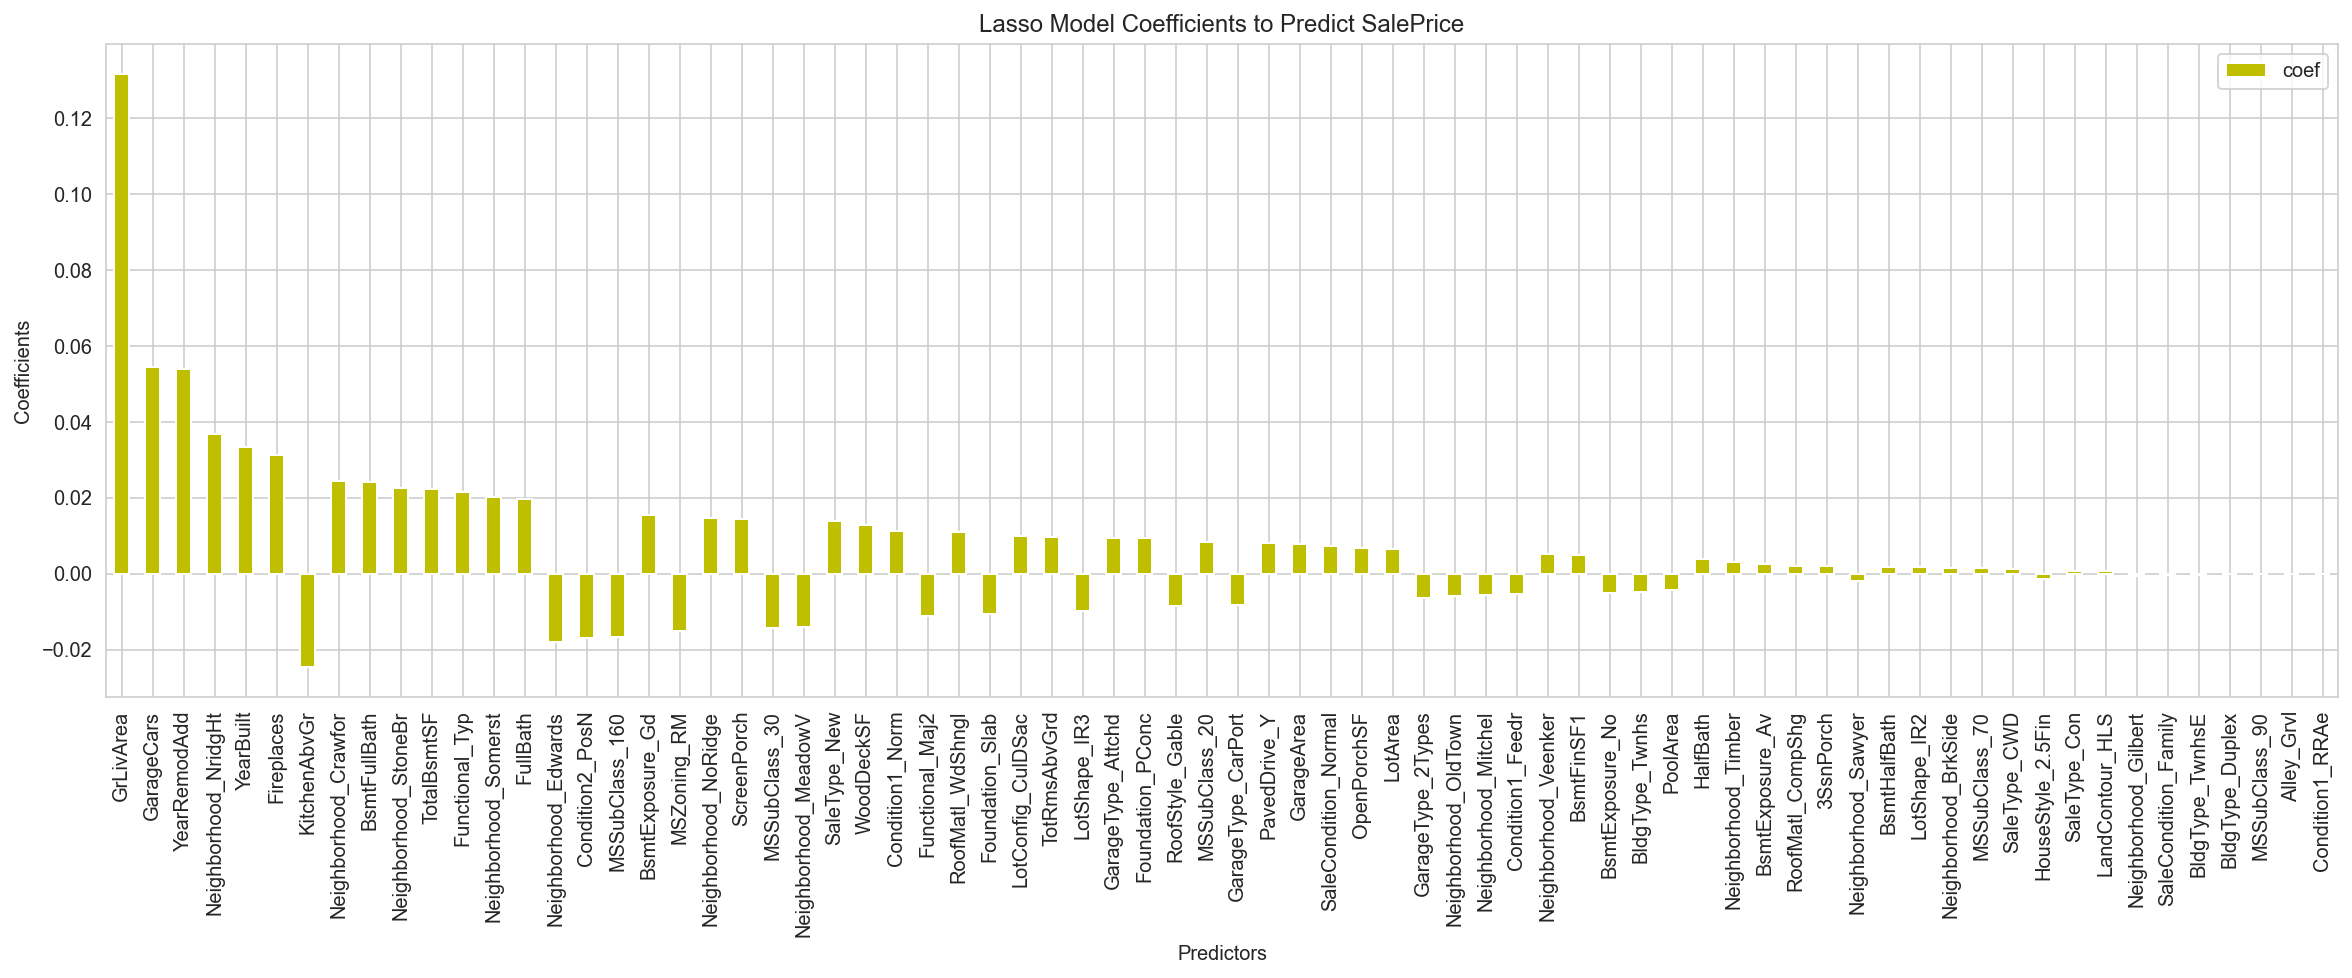

In [368]:
#remove variables with coef==0
coef_downsized= lasso_df[lasso_df['abs_coef']>0]

coef_downsized.plot(kind='bar', y="coef",x="variable", color='y', figsize= (20,6))

plt.title("Lasso Model Coefficients to Predict SalePrice")
plt.ylabel('Coefficients')
plt.xlabel('Predictors')

plt.show()

In [369]:
len(coef_downsized)

72

In [370]:
coef_downsized.head()

variable      coef  abs_coef
11             GrLivArea  0.131644  0.131644
21            GarageCars  0.054435  0.054435
3           YearRemodAdd  0.053990  0.053990
92  Neighborhood_NridgHt  0.036932  0.036932
2              YearBuilt  0.033427  0.033427

### IV. TASK 2: Predict Residuals based on Renovatable Variables

Similar to task 1, we will also be looking at regression models. We will try out the following models.

1. Simple Linear Regression
2. Ridge
3. Lasso
4. Stochastic Gradient Descent Regression
5. Support Vector Regression

In [371]:
get_nulls(q2)

nulls
MasVnrType        8
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtFinType2     37
FireplaceQu     680
GarageFinish     79
GarageQual       79
GarageCond       79
PoolQC         1440
Fence          1169

In [372]:
renov_dummies= my_dummies(q2)
renov_dummies.shape

(1447, 121)

In [373]:
get_nulls(renov_dummies)

Empty DataFrame
Columns: [nulls]
Index: []

In [374]:
X_q2= low_var_threshold(renov_dummies, renov_dummies, 0.001)

The following columns were dropped because there is very small variance in its values: ['Exterior1st_AsphShn', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior2nd_CBlock', 'Exterior2nd_Other', 'ExterCond_Po', 'HeatingQC_Po', 'Electrical_Mix']


In [375]:
X2_train, X2_test= train_test_X(X_q2)
X2_train= X2_train.drop(['YrSold'], axis=1)
X2_test= X2_test.drop(['YrSold'], axis=1)


In [376]:
X2_train.shape

(1275, 112)

In [377]:
ss2= StandardScaler()
X2ss_train= ss2.fit_transform(X2_train)
X2ss_test= ss2.transform(X2_test)

In [378]:
y2_train=lr_residual_train
y2_test= lr_residual_test

#### IV. 0. Baseline

In [379]:
y2_train.mean()

3.4733787897109513e-07

In [380]:
y2_train.sem()

0.003417687183630679

#### IV.1. Linear Regression

 cv score is: -7.835274754359953e+25 
 cv score variance is: 5.091656597782555e+52 
 model score on training data is: 0.21377904095312117 
 RMSE on training data is: 0.10816564200439914 
 model score on testing data is: 0.03312638547185687 
 RMSE on testing data is: 0.13573449809425106 
 RMSE on testing data is: 0.13573449809425106 
 residual mean: 0.0003059677008353163


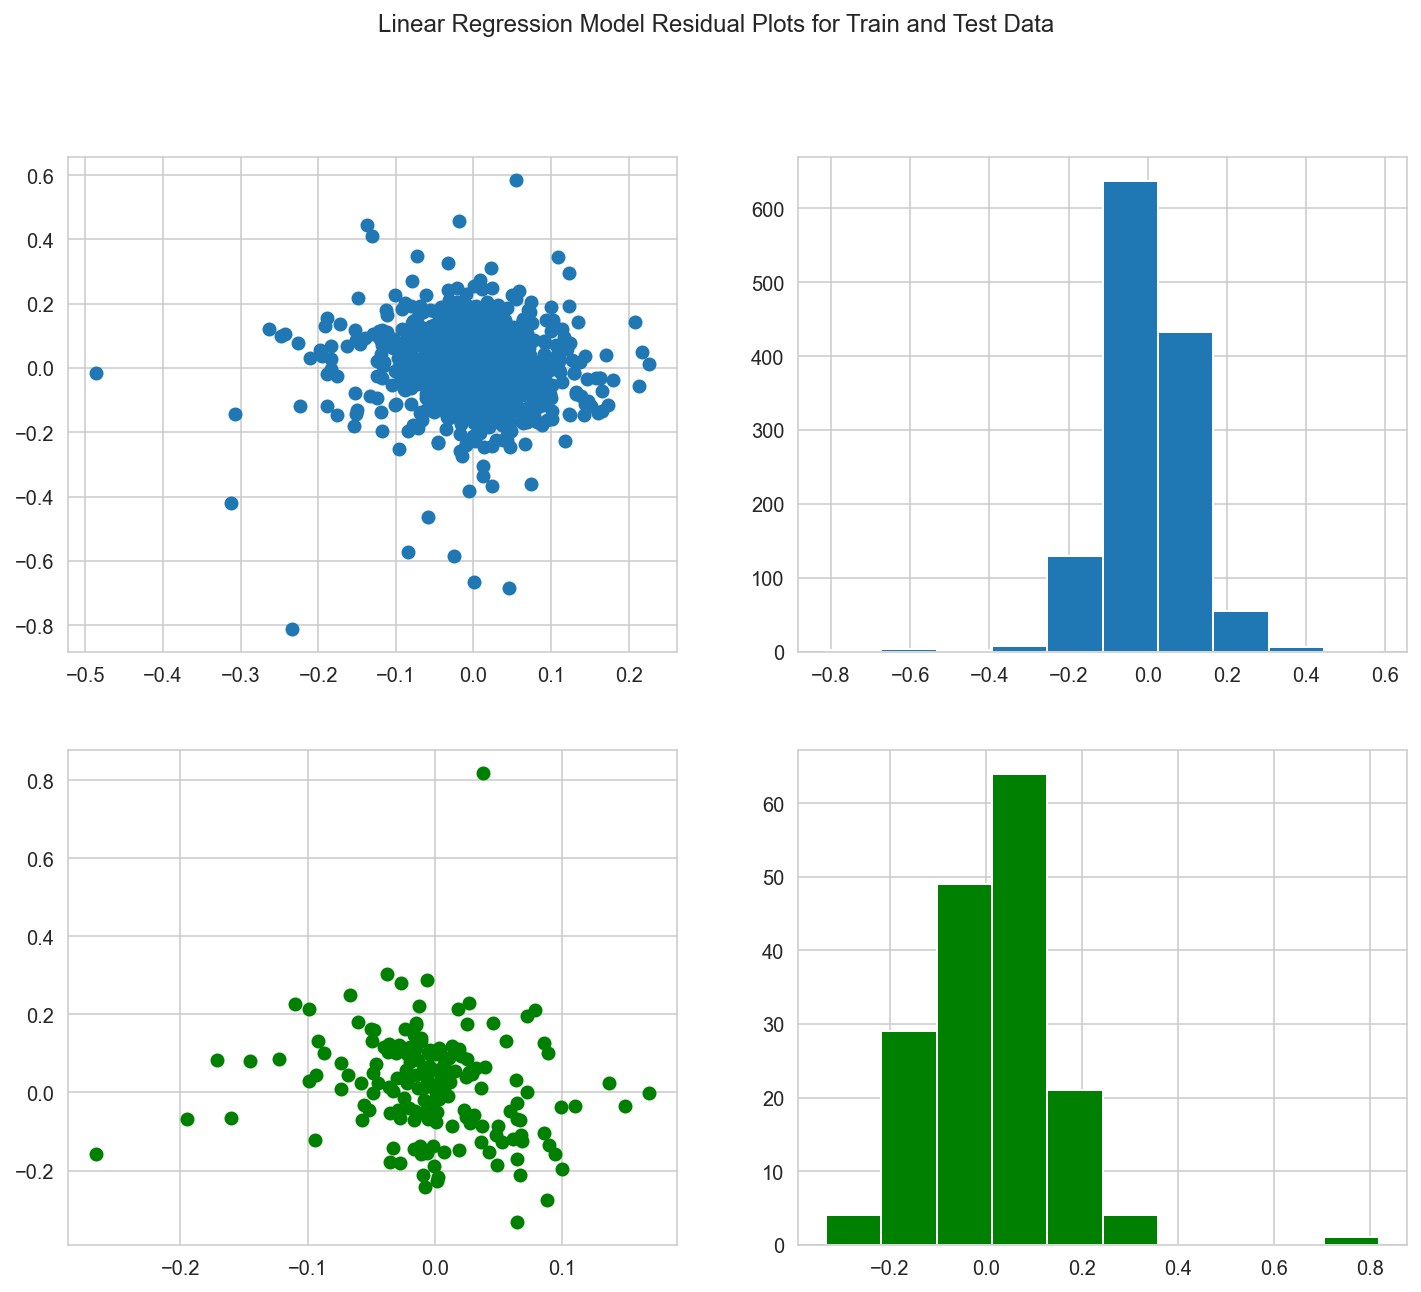

variable      coef  abs_coef
45      PoolQC_Gd -0.009338  0.009338
44      PoolQC_Fa -0.000107  0.000107
43      PoolQC_Ex  0.009289  0.009289
58  OverallQual_9  0.114990  0.114990
57  OverallQual_8  0.208740  0.208740
56  OverallQual_7  0.263046  0.263046
55  OverallQual_6  0.268433  0.268433
54  OverallQual_5  0.265625  0.265625
53  OverallQual_4  0.148193  0.148193
52  OverallQual_3  0.052551  0.052551

In [381]:
q2_lr_df, q2_lr_results, q2_lr_residual_train, q2_lr_residual_test= model_func('Linear Regression', X2ss_train,y2_train,X2ss_test, y2_test, X2_train.columns, 'variable')
q2_lr_df.head(10)

#### IV.2. Ridge

 cv score is: 0.04710755021000189 
 cv score variance is: 0.0019585911957968483 
 model score on training data is: 0.1534164126902262 
 RMSE on training data is: 0.11224110822318903 
 model score on testing data is: 0.08059152797398694 
 RMSE on testing data is: 0.13236087749145314 
 RMSE on testing data is: 0.13236087749145314 
 residual mean: -1.1809725310963675e-18


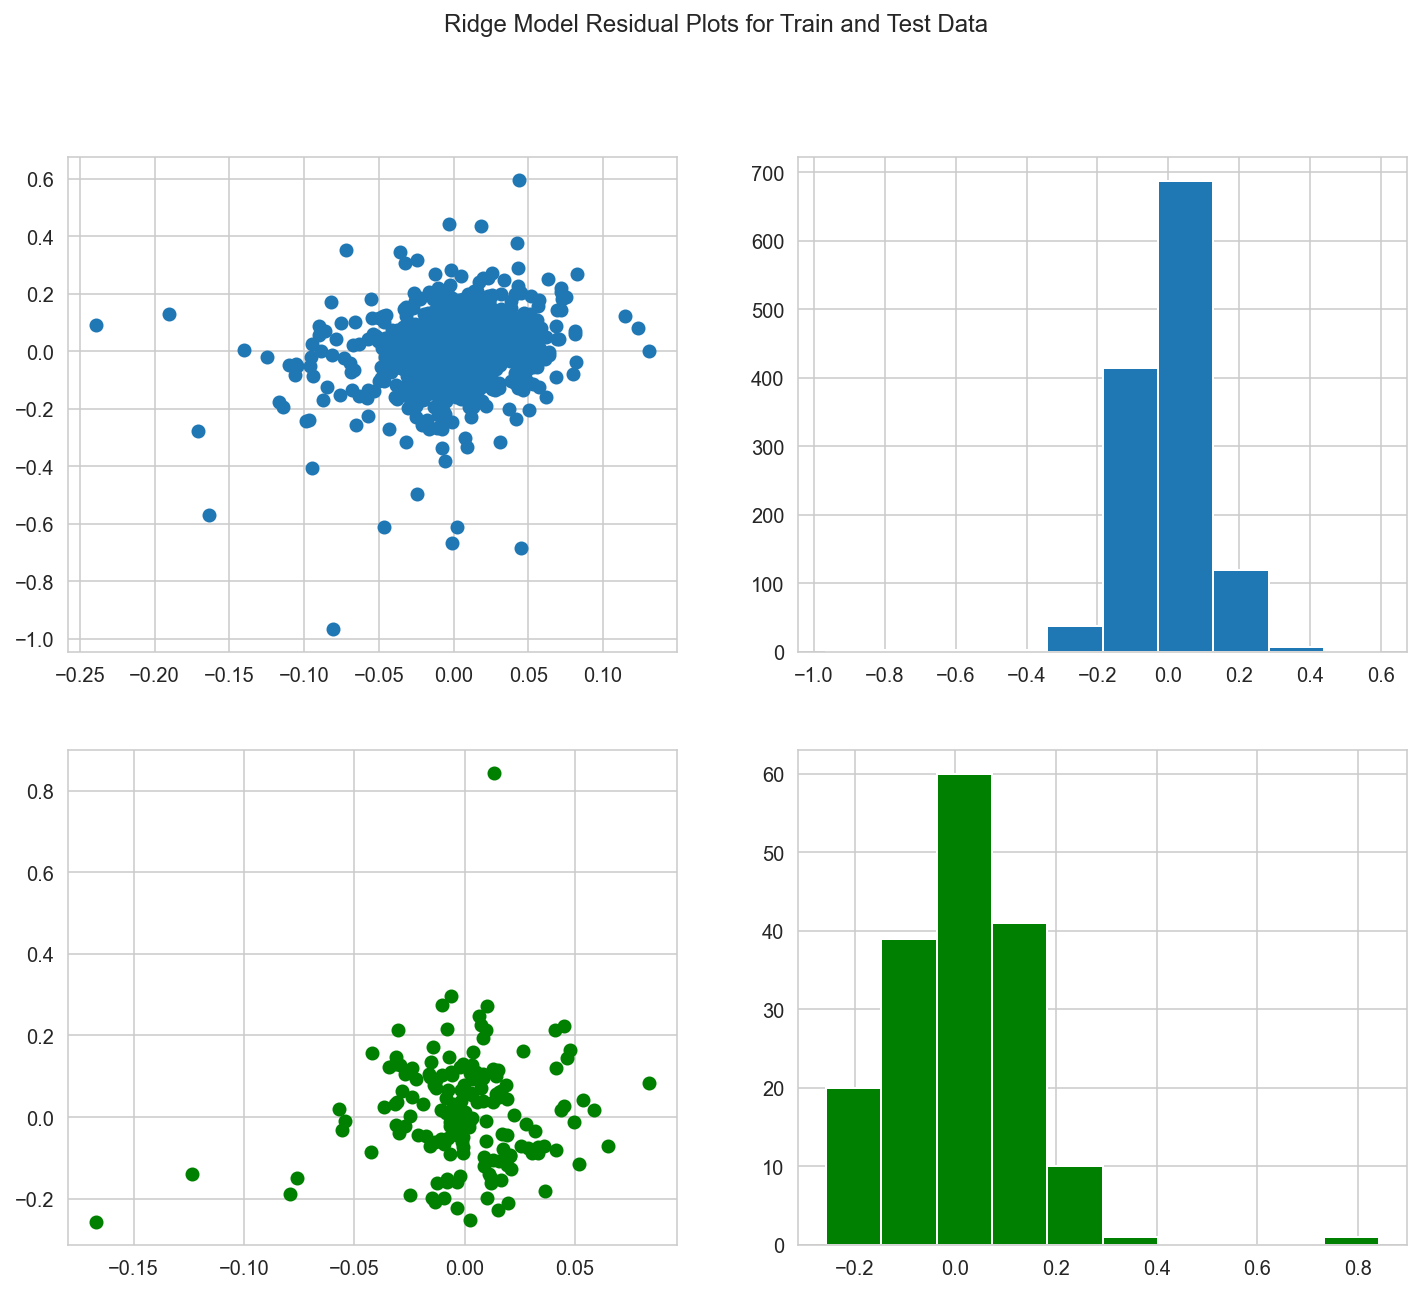

variable      coef  abs_coef
45      PoolQC_Gd -0.004051  0.004051
44      PoolQC_Fa -0.000407  0.000407
43      PoolQC_Ex  0.002546  0.002546
58  OverallQual_9  0.005212  0.005212
57  OverallQual_8  0.002739  0.002739
56  OverallQual_7  0.001359  0.001359
55  OverallQual_6  0.000023  0.000023
54  OverallQual_5 -0.001710  0.001710
53  OverallQual_4 -0.002462  0.002462
52  OverallQual_3 -0.005398  0.005398

In [382]:
q2_ridge_df, q2_ridge_results, q2_ridge_residual_train, q2_ridge_residual_test= model_func('Ridge', X2ss_train,y2_train,X2ss_test, y2_test, X2_train.columns, 'variable')
q2_ridge_df.head(10)

#### IV.3. Lasso

 cv score is: 0.05272001221101876 
 cv score variance is: 0.0036653864941424514 
 model score on training data is: 0.134993635101065 
 RMSE on training data is: 0.11345579292119932 
 model score on testing data is: 0.09377547874154224 
 RMSE on testing data is: 0.13140844970968985 
 RMSE on testing data is: 0.13140844970968985 
 residual mean: -5.91302606007467e-18


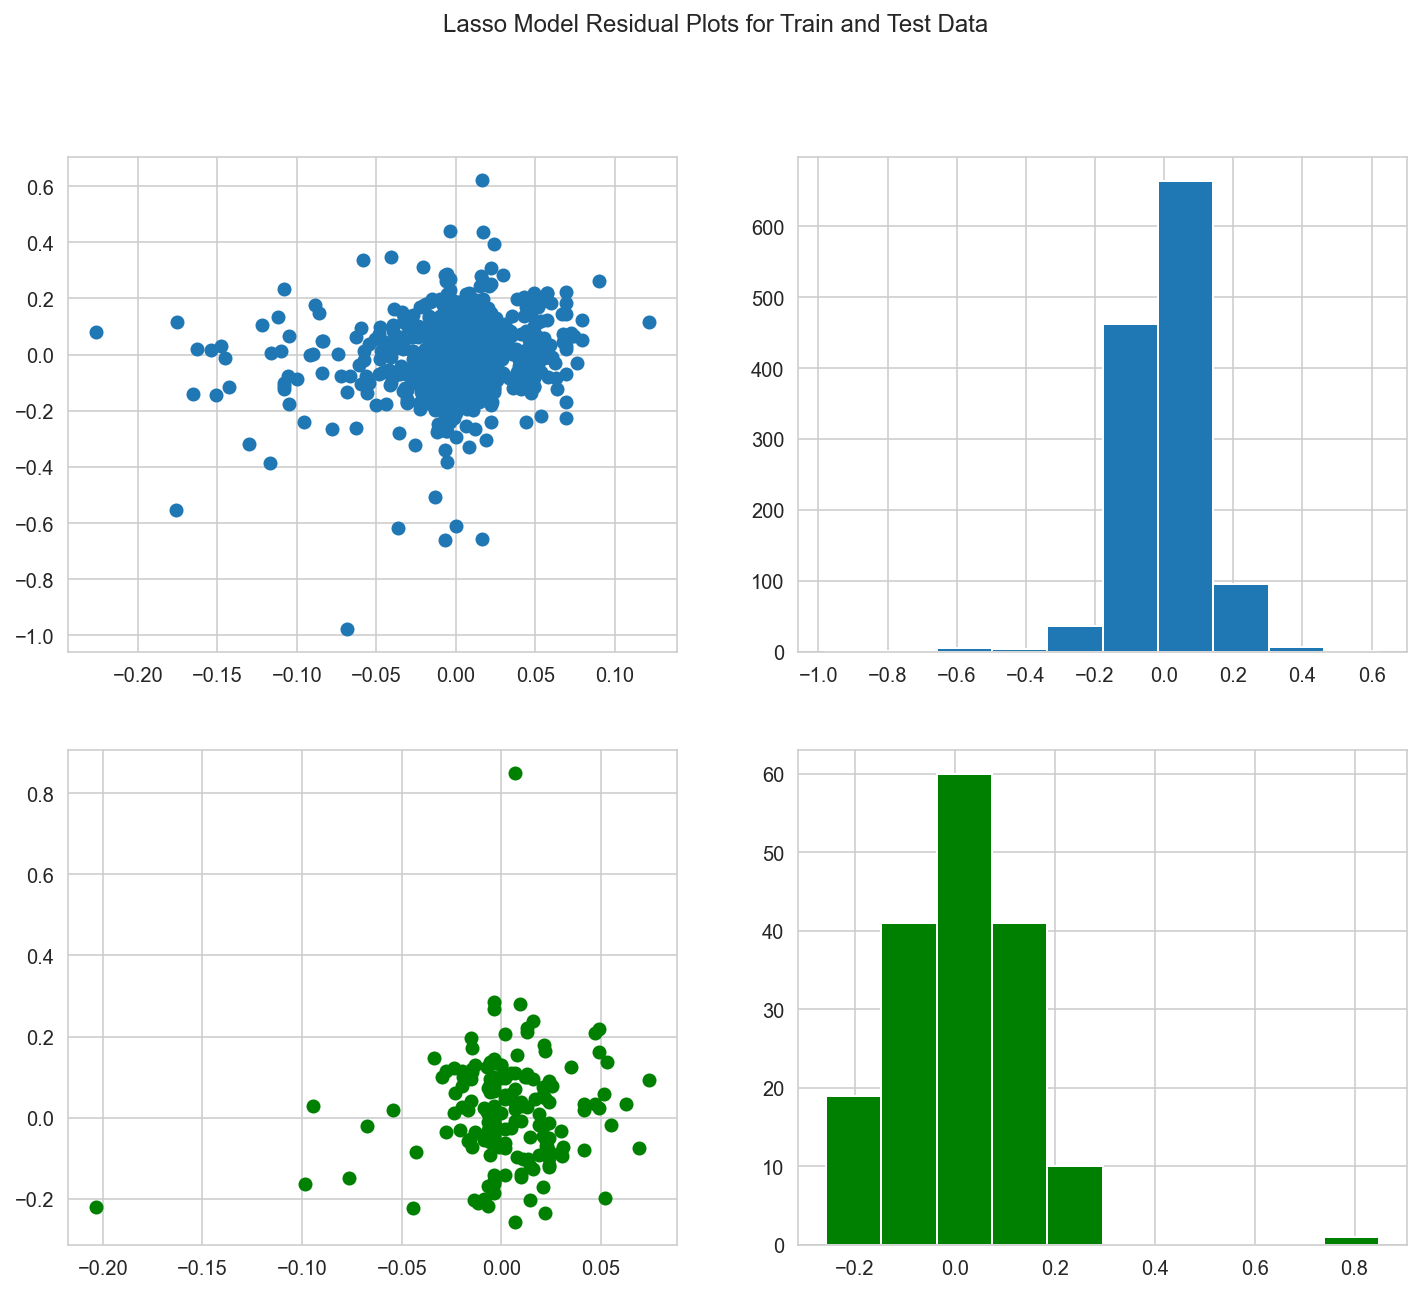

variable      coef  abs_coef
45      PoolQC_Gd -0.003152  0.003152
44      PoolQC_Fa -0.000000  0.000000
43      PoolQC_Ex  0.000982  0.000982
58  OverallQual_9  0.008845  0.008845
57  OverallQual_8  0.001844  0.001844
56  OverallQual_7  0.000000  0.000000
55  OverallQual_6 -0.000000  0.000000
54  OverallQual_5 -0.000000  0.000000
53  OverallQual_4 -0.000000  0.000000
52  OverallQual_3 -0.006311  0.006311

In [383]:
q2_lasso_df, q2_lasso_results, q2_lasso_residual_train, q2_lasso_residual_test= model_func('Lasso', X2ss_train,y2_train,X2ss_test, y2_test, X2_train.columns, 'variable')
q2_lasso_df.head(10)

#### IV.4.Stochastic Gradient Descent Regression

SGD best params: {'alpha': 0.01778279410038923, 'loss': 'huber', 'penalty': 'elasticnet'}
SGD best score: 0.0795352718999838
SGD best estimator: SGDRegressor(alpha=0.01778279410038923, loss='huber', penalty='elasticnet')
 cv score is: 0.0717775959603392 
 cv score variance is: 0.001960069198838178 
 model score on training data is: 0.12071243325810344 
 RMSE on training data is: 0.11438853289070848 
 model score on testing data is: 0.07699072590317324 
 RMSE on testing data is: 0.13261981549320515 
 RMSE on testing data is: 0.13261981549320515 
 residual mean: -0.0026211947098143677


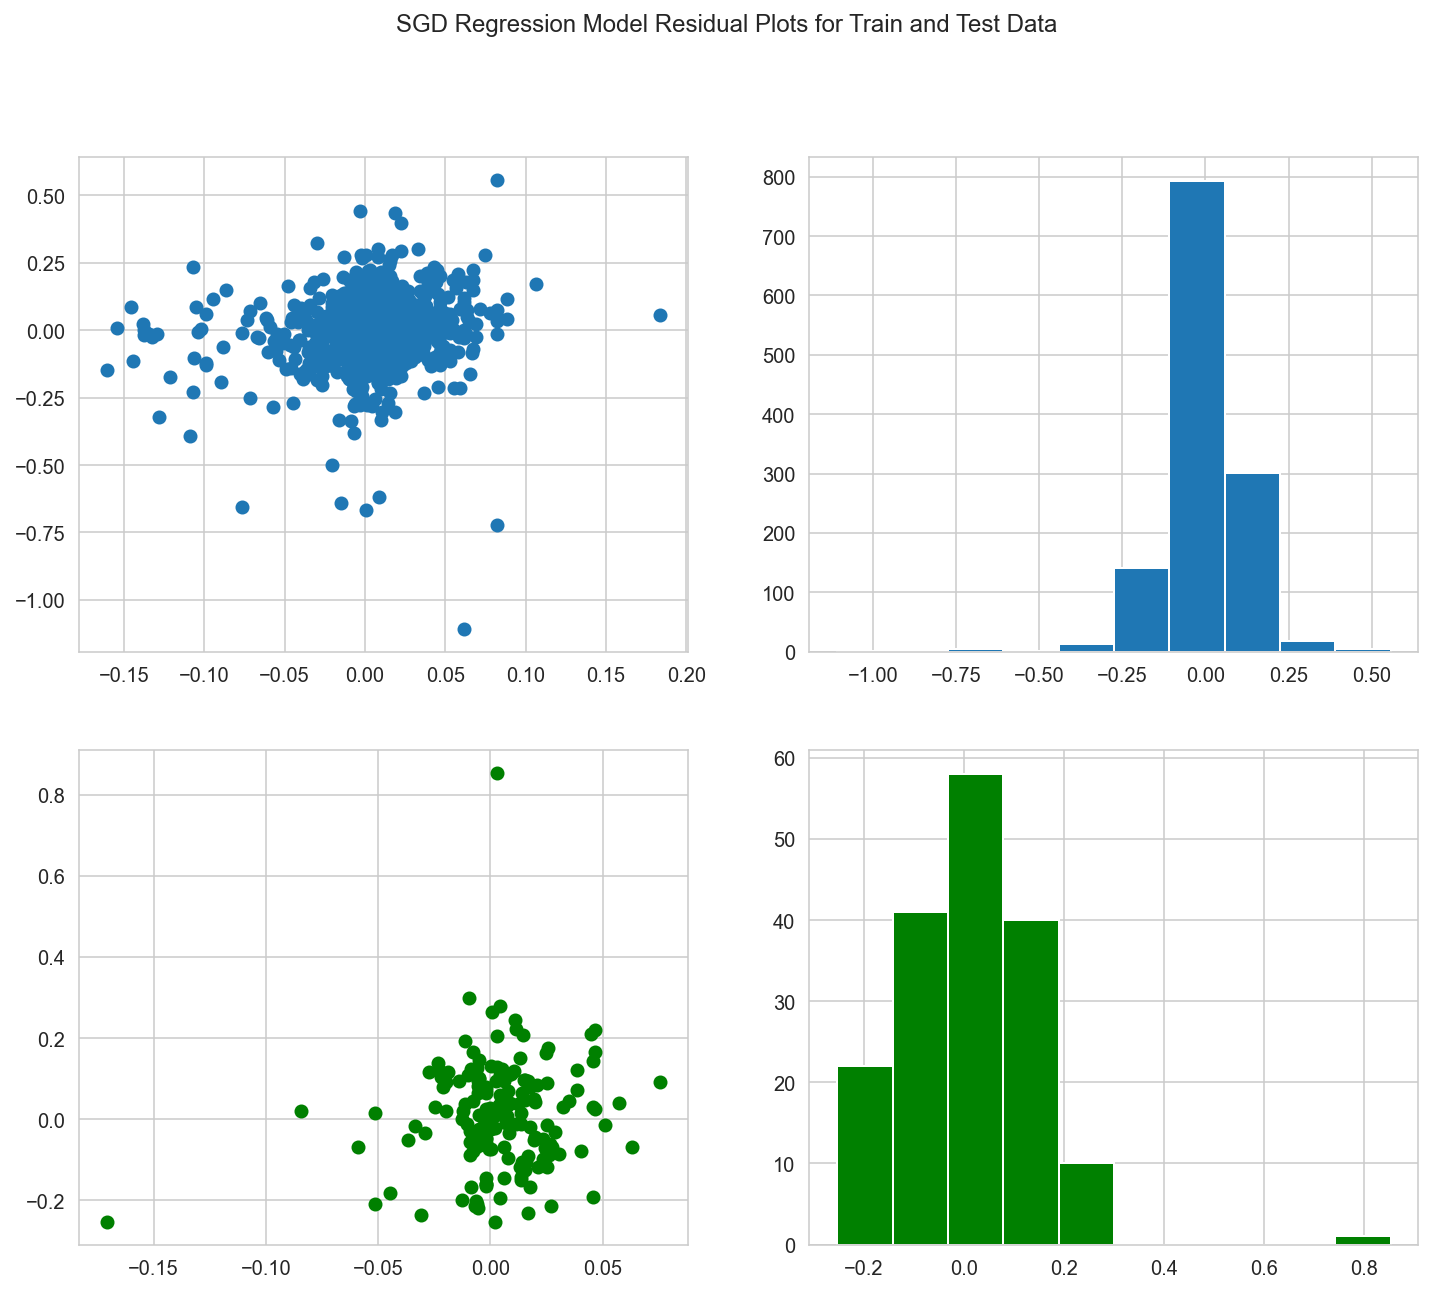

variable      coef  abs_coef
45      PoolQC_Gd  0.000000  0.000000
44      PoolQC_Fa  0.000000  0.000000
43      PoolQC_Ex  0.000000  0.000000
58  OverallQual_9  0.007360  0.007360
57  OverallQual_8  0.003679  0.003679
56  OverallQual_7  0.001343  0.001343
55  OverallQual_6  0.000000  0.000000
54  OverallQual_5  0.000000  0.000000
53  OverallQual_4 -0.000543  0.000543
52  OverallQual_3 -0.003947  0.003947

In [384]:
q2_sgd_df, q2_sgd_results, q2_sgd_residual_train, q2_sgd_residual_test= model_func('SGD Regression', X2ss_train,y2_train,X2ss_test, y2_test, X2_train.columns, 'variable')
q2_sgd_df.head(10)

#### IV.5. Support Vector Regression

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 9006 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:    3.6s finished


SVR best params: {'C': 0.001, 'epsilon': 1.0, 'gamma': 1e-05, 'kernel': 'linear'}
SVR best score: -3.286400765339824
SVR best estimator: SVR(C=0.001, epsilon=1.0, gamma=1e-05, kernel='linear')
model coefs is multidimensional
 cv score is: -3.234519133995832 
 cv score variance is: 3.9515382291601986 
 model score on training data is: -2.7935931739668414 
 RMSE on training data is: 0.2375977925336662 
 model score on testing data is: -2.4771391419740403 
 RMSE on testing data is: 0.2574046700338935 
 RMSE on testing data is: 0.2574046700338935 
 residual mean: 0.20389125742411263


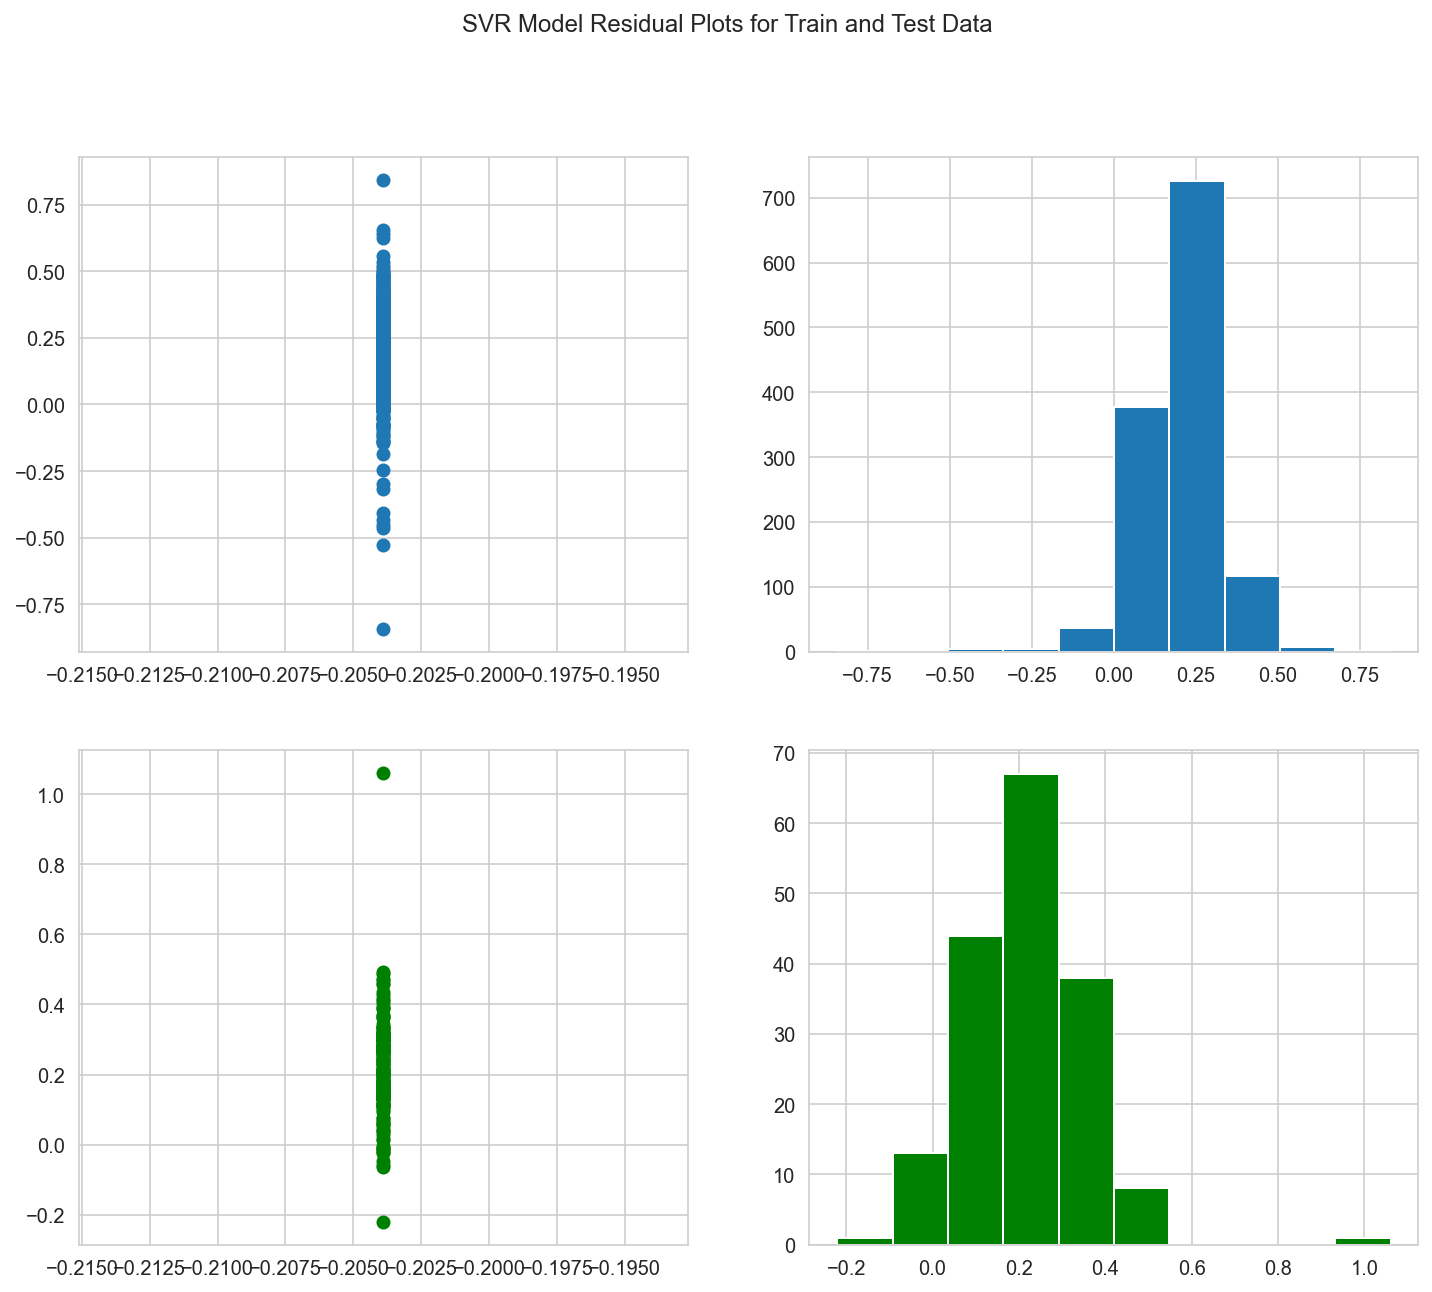

In [385]:
q2_svr_df, q2_svr_results, q2_svr_residual_train, q2_svr_residual_test= model_func('SVR', X2ss_train,y2_train,X2ss_test, y2_test, X2_train.columns, 'variable')

#### SUMMARY OF RESULTS
Below is a summary of performance of our models. Comparing the performance of the models, again Ridge, Lasso and SGDR performed better than the other 2. of the three that performed better, SGDR model performed gave the best results. It had the highest cross validated score with the lowest variance on those scores. Its RMSE on both the train and test data are comparable to both Ridge and Lasso. 

SGDR was able to reduce the number of coefficients used in the model down to a third.

The coefficients indicate the impact of renovatable features on our model in q1. Positive coefficient indicate underpricing and negative indicate overpricing. 

Intrepreting the result, we can see below that the overall quality and overall condition of the property could explain some of the errors in our model for q1. Our q1 model is overpricing the SalePrice for houses with worse conditions and quality and underpricing house with better to excellent conditions and quality.

Given the low scores from our model, I am not confident that this is a model that we can trust. However, we can explore bringing in our q2 variables with highest absolute value of coefficients in our q1 model in future study on this dataset.

In [386]:
summary2={}
summary2['LR']= q2_lr_results
summary2['Ridge']=q2_ridge_results
summary2['Lasso']=q2_lasso_results
summary2['SGDR']=q2_sgd_results
summary2['SVR']=q2_svr_results
summary2=pd.DataFrame(summary2).T
summary2

cv_score  cv_score_variance  score_on_train  RMSE_train  \
LR    -7.835275e+25       5.091657e+52        0.213779    0.108166   
Ridge  4.710755e-02       1.958591e-03        0.153416    0.112241   
Lasso  5.272001e-02       3.665386e-03        0.134994    0.113456   
SGDR   7.177760e-02       1.960069e-03        0.120712    0.114389   
SVR   -3.234519e+00       3.951538e+00       -2.793593    0.237598   

       score_on_test  RMSE_test  residual_mean_train  residual_mean_test  \
LR          0.033126   0.135734         3.059677e-04            0.015813   
Ridge       0.080592   0.132361        -1.180973e-18            0.013375   
Lasso       0.093775   0.131408        -5.913026e-18            0.010998   
SGDR        0.076991   0.132620        -2.621195e-03            0.009387   
SVR        -2.477139   0.257405         2.038913e-01            0.217260   

       yhat_train_mean  yhat_test_mean  
LR       -3.056204e-04       -0.002443  
Ridge     3.473379e-07       -0.000006  
Lasso     3.473379e-07        0.002372  
SGDR      2.621542e-03        0.003983  
SVR      -2.038909e-01       -0.203891

#### Looking at the coefficients for our predictors

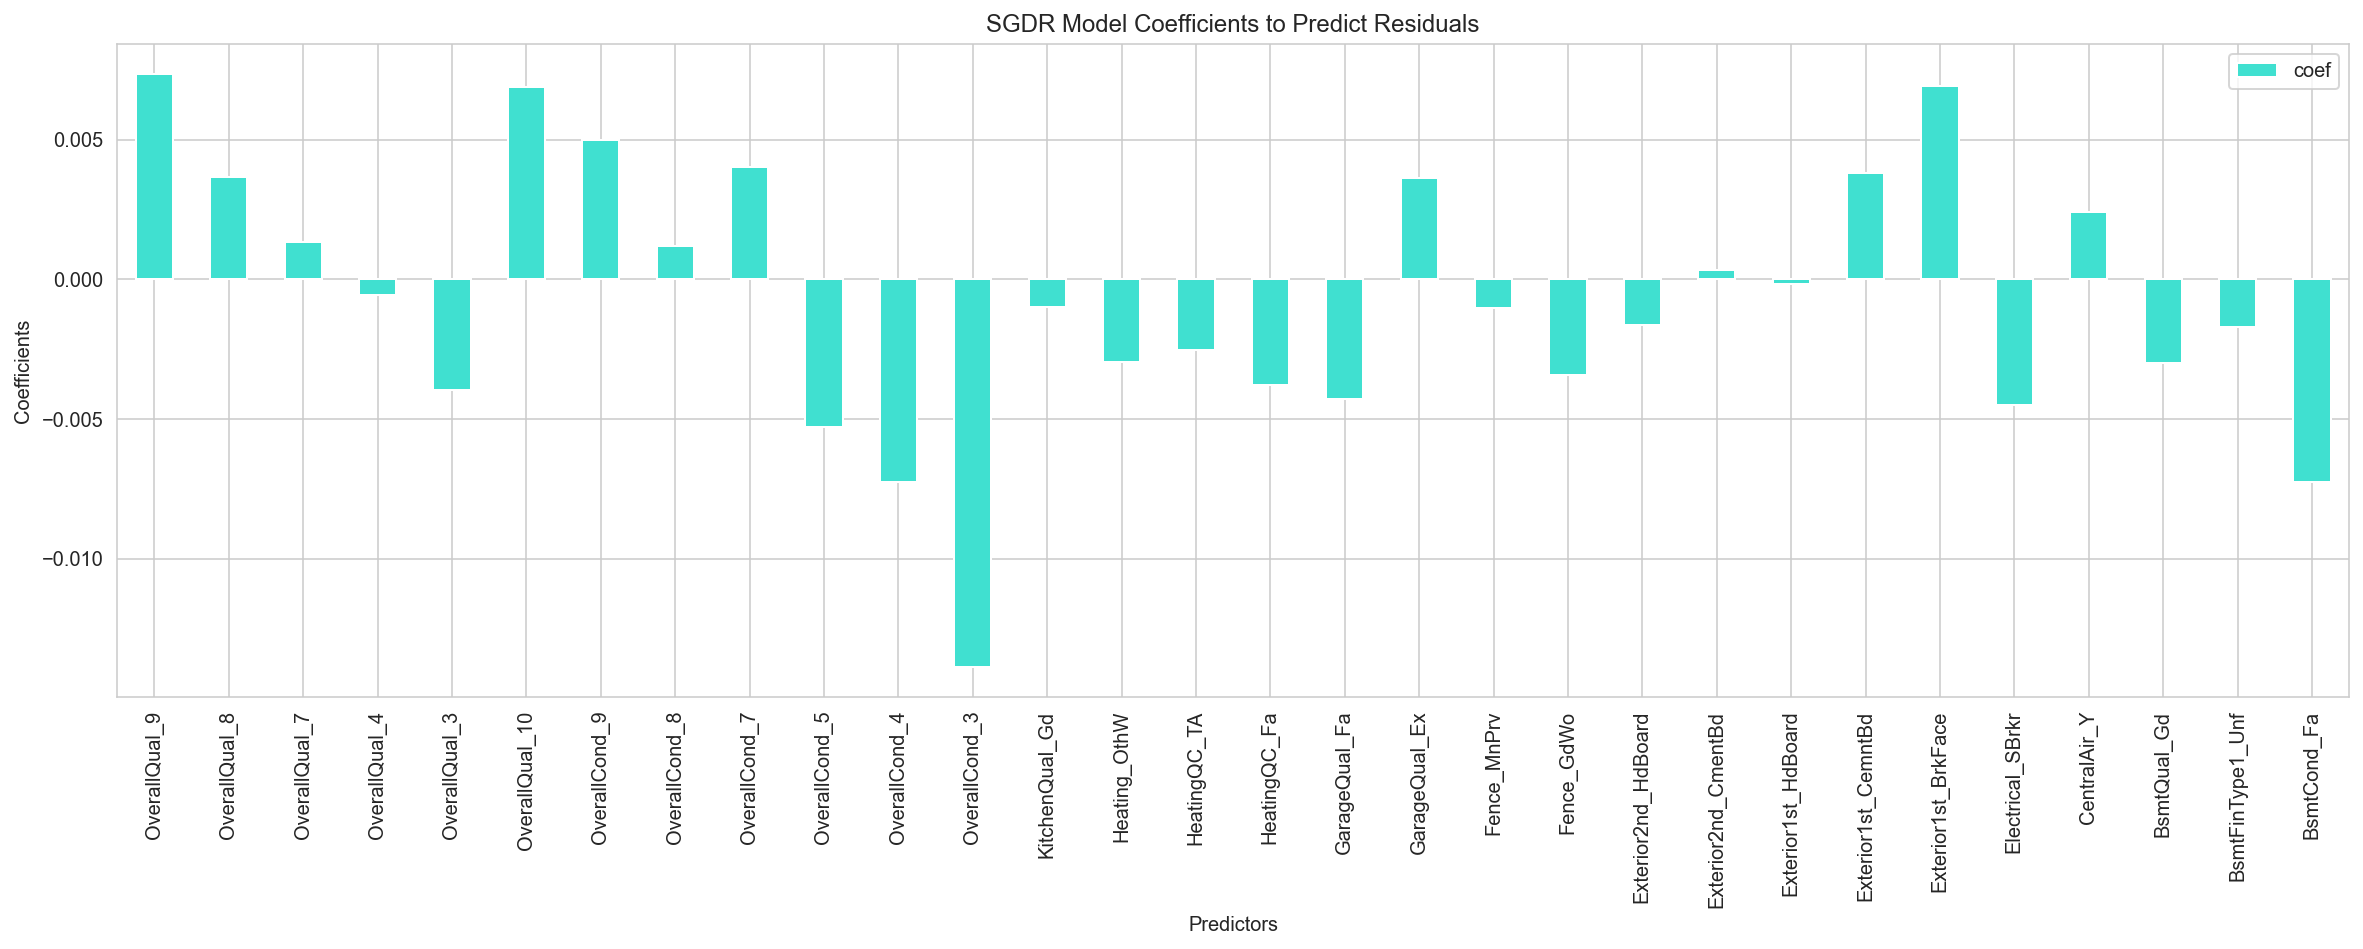

In [387]:
#remove variables with coef==0
q2_coef_downsized= q2_sgd_df[q2_sgd_df['abs_coef']>0]

q2_coef_downsized.plot(kind='bar', y="coef",x="variable", color='turquoise', figsize= (20,6))

plt.title("SGDR Model Coefficients to Predict Residuals")
plt.ylabel('Coefficients')
plt.xlabel('Predictors')

plt.show()

In [388]:
len(q2_sgd_df)

112

In [389]:
len(q2_coef_downsized)

30

### V. TASK 3: Predict Abnormal Sale Condition

Different from tasks 1 and 2 as we will be implementing Classification models for this. 

I will try the following models:
1. KNN Classification
2. Simple Logistic Regression
3. Logistic Regression with L1 Penalty
4. Logistic Regression with L2 Penalty
5. Linear SVC

In [390]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


In [391]:
# take the original cleaned data set
q3= house_imputed.copy()
q3.SaleCondition.value_counts()

Normal     1191
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [392]:
#reduce the number of classes for our target variable. 
#I will combine Partial, Family, Alloca amd AdjLand into a single variable called Other
q3.SaleCondition.replace('Family','Other',inplace=True)
q3.SaleCondition.replace('Alloca','Other',inplace=True)
q3.SaleCondition.replace('AdjLand','Other',inplace=True)
q3.SaleCondition.replace('Partial','Other',inplace=True)
q3.SaleCondition.value_counts()

Normal     1191
Other       160
Abnorml      96
Name: SaleCondition, dtype: int64

In [393]:
#due to the imbalance in our target variable with Normal being 10 times the number of Abnormal, 
# I will downsize the sample. 
q3_df = q3.groupby("SaleCondition").sample(n=96, random_state=1)

In [394]:
q3_df.SaleCondition.value_counts()

Other      96
Normal     96
Abnorml    96
Name: SaleCondition, dtype: int64

In [395]:
#split the y into train and test
y3_train= q3_df[q3_df['YrSold']<2010]['SaleCondition'].copy()
y3_test= q3_df[q3_df['YrSold']>=2010]['SaleCondition'].copy()

In [396]:
#dummy my X variables
X3_df= my_dummies(q3_df.drop('SaleCondition',axis=1))

In [397]:
#drop low variance columns
X3=low_var_threshold(X3_df,X3_df)

The following columns were dropped because there is very small variance in its values: []


In [398]:
#split X into train and test
X3_train, X3_test= train_test_X(X3)

In [399]:
#scale my X
ss3= StandardScaler()
X3ss_train=ss3.fit_transform(X3_train)
X3ss_test=ss3.transform(X3_test)

In [400]:
get_nulls(X3_train)

Empty DataFrame
Columns: [nulls]
Index: []

#### V.0.Baseline

In [401]:
y3_train.value_counts(normalize=True)

Other      0.352490
Abnorml    0.333333
Normal     0.314176
Name: SaleCondition, dtype: float64

#### V.1. KNN Classification

In [402]:
#Define KNN classifier, 

knn= KNeighborsClassifier(n_neighbors=25)
 
#Set up Pipelines for classifier and use pipe within a cross val score wrapper
knn_cv= cross_val_score(knn, X3ss_train, y3_train, cv=10)
 
#scores = accuracy. (The amount of correct predictions/total predictions )
knn_score= np.mean(knn_cv)
knn_var= np.var(knn_cv)

In [403]:
knn.fit(X3ss_train, y3_train)
# predictions
yhat_k = knn.predict(X3ss_train)

#create confusion matrix

conmat_k = np.array(confusion_matrix(y3_train, yhat_k))

confusionk = pd.DataFrame(conmat_k, index=['abnormal', 'normal', 'other'],
                         columns=['predicted_abnormal','predicted_normal', 'predicted_other'])
confusionk

predicted_abnormal  predicted_normal  predicted_other
abnormal                  47                24               16
normal                    25                39               18
other                      8                 7               77

In [404]:
#score test data
knn.score(X3ss_test, y3_test)

0.6666666666666666

#### V. 2. Simple Logistic Regression

In [405]:
# pass n_neighbour and C parameter values to fresh models for Pipeline
logR= LogisticRegression(C=0.01, max_iter= 10000)

#Set up Pipelines for classifier and use pipe within a cross val score wrapper

lr_cv= cross_val_score(logR, X3ss_train, y3_train, cv=10)

#Get scores for Logistic regression cross_val
lr_score= np.mean(lr_cv)
lr_var= np.var(lr_cv)

In [406]:
logR.fit(X3ss_train, y3_train)
# predictions
yhat = logR.predict(X3ss_train)

#create confusion matrix

conmat = np.array(confusion_matrix(y3_train, yhat))

confusion = pd.DataFrame(conmat, index=['abnormal', 'normal', 'other'],
                         columns=['predicted_abnormal','predicted_normal', 'predicted_other'])
confusion

predicted_abnormal  predicted_normal  predicted_other
abnormal                  80                 5                2
normal                     5                77                0
other                      6                 1               85

In [407]:
#get the coefficients
logR_coefs = pd.DataFrame({'variable':X3_train.columns,
                            'coef':pd.DataFrame(logR.coef_).T[0],
                            'abs_coef':np.abs(pd.DataFrame(logR.coef_).T[0])
                            })
logR_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [408]:
#get test score
logR.score(X3ss_test, y3_test)

0.5925925925925926

#### V.3. Logistic Regression with Ridge penalty

In [409]:
#setup the gridsearch param

logR_l2_params = {
    'solver':['lbfgs'],
    'penalty':['l2'],
    'Cs':range(-200,200,25)
}

logR_l2= LogisticRegressionCV()
logR_l2_gs = GridSearchCV(logR_l2, logR_l2_params, cv=5, verbose=False)

In [410]:
logR_l2_gs.fit(X3ss_train, y3_train)

GridSearchCV(cv=5, estimator=LogisticRegressionCV(),
             param_grid={'Cs': range(-200, 200, 25), 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             verbose=False)

In [411]:
print(logR_l2_gs.best_params_)
print(logR_l2_gs.best_score_)
print(logR_l2_gs.best_estimator_)
best_logR_l2 = logR_l2_gs.best_estimator_

{'Cs': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.6243831640058055
LogisticRegressionCV(Cs=50)


In [412]:
#try crossval and get mean and var of scores
logR_R_cv= cross_val_score(best_logR_l2, X3_train, y3_train, cv=10)
logR_R_score= np.mean(logR_R_cv)
logR_R_var= np.var(logR_R_cv)

In [413]:
best_logR_l2.fit(X3_train, y3_train)
# predictions
yhat_R = best_logR_l2.predict(X3_train)
#create confusion matrix
conmatR = np.array(confusion_matrix(y3_train, yhat_R))

confusionR = pd.DataFrame(conmatR, index=['abnormal', 'normal', 'other'],
                         columns=['predicted_abnormal','predicted_normal', 'predicted_other'])
confusionR

predicted_abnormal  predicted_normal  predicted_other
abnormal                  53                17               17
normal                    28                32               22
other                     19                 9               64

In [414]:
#get coef
logR_R_coefs = pd.DataFrame({'variable':X3_train.columns,
                            'coef':pd.DataFrame(best_logR_l2.coef_).T[0],
                            'abs_coef':np.abs(pd.DataFrame(best_logR_l2.coef_).T[0])
                            })
logR_R_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [415]:
# logR_coefs.head(20)

In [416]:
#score with test data
best_logR_l2.score(X3ss_test, y3_test)

0.4444444444444444

#### V.4. Logistic Regression with L1 penalty

In [417]:
#set search params
logR_l1_params={
    'solver': ['liblinear'],
    'penalty':['l1'],
    'Cs':range(-200,200,25)
}

logR_l1= LogisticRegressionCV()
logR_l1_gs = GridSearchCV(logR_l1, logR_l1_params, cv=5, verbose=1, n_jobs=-1)

In [418]:
logR_l1_gs.fit(X3ss_train, y3_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   51.3s finished


GridSearchCV(cv=5, estimator=LogisticRegressionCV(), n_jobs=-1,
             param_grid={'Cs': range(-200, 200, 25), 'penalty': ['l1'],
                         'solver': ['liblinear']},
             verbose=1)

In [419]:
print(logR_l1_gs.best_params_)
print(logR_l1_gs.best_score_)
print(logR_l1_gs.best_estimator_)
best_logR_l1 = logR_l1_gs.best_estimator_

{'Cs': 75, 'penalty': 'l1', 'solver': 'liblinear'}
0.6742380261248186
LogisticRegressionCV(Cs=75, penalty='l1', solver='liblinear')


In [420]:
#try crossval and get mean and var of scores
logR_L_cv= cross_val_score(best_logR_l1, X3_train, y3_train, cv=10)
logR_L_score= np.mean(logR_L_cv)
logR_L_var= np.var(logR_L_cv)

In [421]:
best_logR_l1.fit(X3_train, y3_train)
# predictions
yhat_L = best_logR_l1.predict(X3_train)
#create confusion matrix
conmatL = np.array(confusion_matrix(y3_train, yhat_L))

confusionL = pd.DataFrame(conmatL, index=['abnormal', 'normal', 'other'],
                         columns=['predicted_abnormal','predicted_normal', 'predicted_other'])
confusionL

predicted_abnormal  predicted_normal  predicted_other
abnormal                  82                 5                0
normal                     9                72                1
other                      2                 8               82

In [422]:
#get coef
logR_L_coefs = pd.DataFrame({'variable':X3_train.columns,
                            'coef':pd.DataFrame(best_logR_l1.coef_).T[0],
                            'abs_coef':np.abs(pd.DataFrame(best_logR_l1.coef_).T[0])
                            })
logR_L_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [423]:
logR_L_coefs.head()

variable      coef  abs_coef
245          SaleType_New -8.146842  8.146842
247           SaleType_WD -3.380609  3.380609
135  Neighborhood_NoRidge  2.666633  2.666633
103         MSSubClass_80  2.595112  2.595112
66         FireplaceQu_Gd -2.399080  2.399080

In [424]:
#score using test data
best_logR_l1.score(X3ss_test, y3_test)

0.5555555555555556

#### SUMMARY OF RESULTS

In [425]:
q3_compare=pd.DataFrame()
q3_compare['Model']=['KNN','LR', 'Ridge', "Lasso"]
q3_compare['Score']=[knn_score,lr_score, logR_R_score, logR_L_score]
q3_compare['Var']=[knn_var,lr_var, logR_R_var,logR_L_var ]
q3_compare['Test Score']=[knn.score(X3_test, y3_test),logR.score(X3_test, y3_test),best_logR_l2.score(X3ss_test, y3_test),best_logR_l1.score(X3ss_test, y3_test)]
q3_compare['TP']=[confusionk.iloc[0][0],confusion.iloc[0][0],confusionR.iloc[0][0],confusionL.iloc[0][0]]
q3_compare['FN']=[confusionk.iloc[0][1:].sum(),confusion.iloc[0][1:].sum(),confusionR.iloc[0][1:].sum(),confusionL.iloc[0][1:].sum()]
q3_compare['FP']=[confusionk.predicted_abnormal[1:].sum(),confusion.predicted_abnormal[1:].sum(),confusionR.predicted_abnormal[1:].sum(),confusionL.predicted_abnormal[1:].sum()]

 
q3_compare

Model     Score       Var  Test Score  TP  FN  FP
0    KNN  0.566524  0.013629    0.148148  47  40  33
1     LR  0.639601  0.001969    0.148148  80   7  11
2  Ridge  0.498006  0.003729    0.444444  53  34  47
3  Lasso  0.628490  0.005797    0.555556  82   5  11

Based on the above, the logistic regression with lasso performed best among our models. It gave us good score as well as giving us the highest true positive rating. It also gave the lowest false negative and false positive among our models.

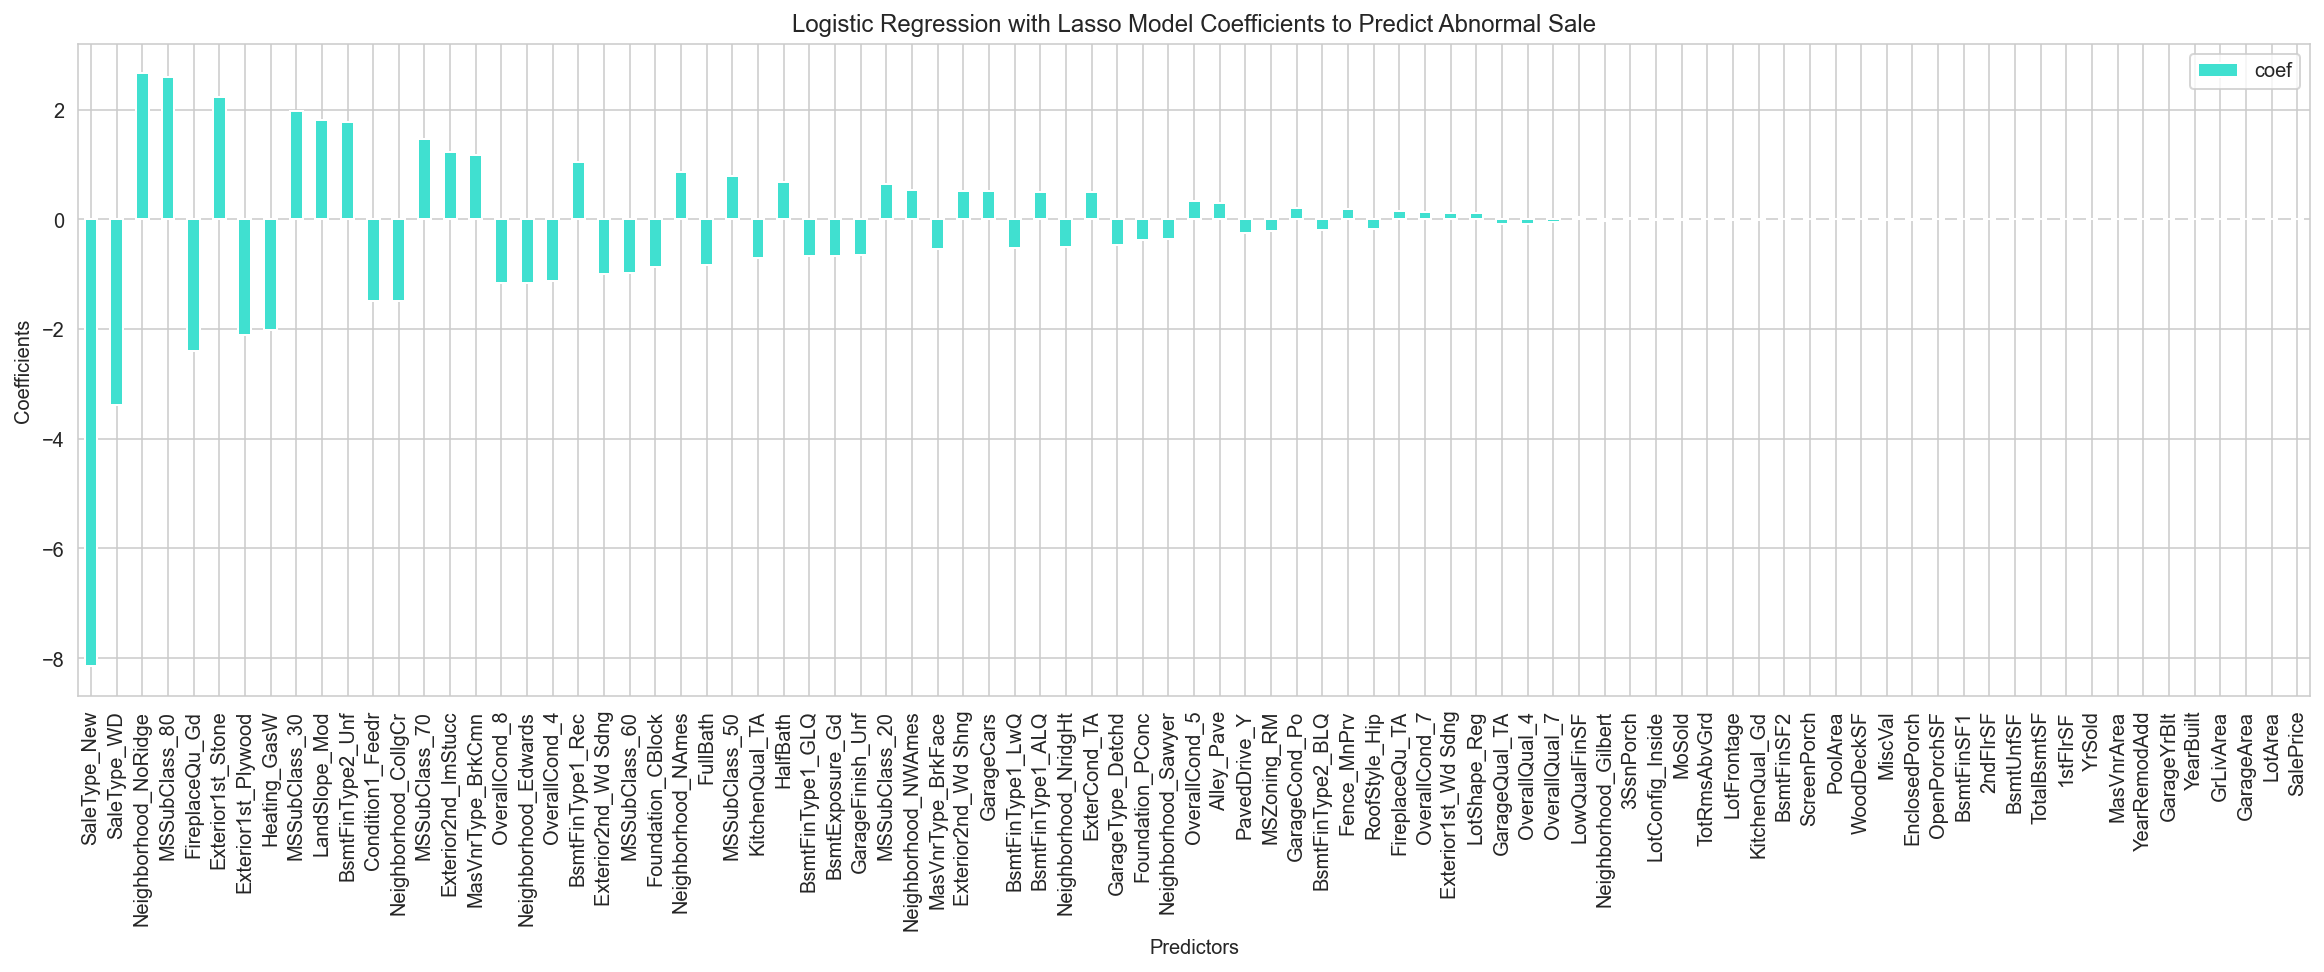

In [426]:
#remove variables with coefs that are zero
q3_coef_downsized= logR_L_coefs[logR_L_coefs['abs_coef']>0]

q3_coef_downsized.plot(kind='bar', y="coef",x="variable", color='turquoise', figsize= (20,6))

plt.title("Logistic Regression with Lasso Model Coefficients to Predict Abnormal Sale")
plt.ylabel('Coefficients')
plt.xlabel('Predictors')

plt.show()

In [427]:
len(logR_L_coefs)

248

In [428]:
len(q3_coef_downsized)

87

In [429]:
q3_coef_downsized.head()

variable      coef  abs_coef
245          SaleType_New -8.146842  8.146842
247           SaleType_WD -3.380609  3.380609
135  Neighborhood_NoRidge  2.666633  2.666633
103         MSSubClass_80  2.595112  2.595112
66         FireplaceQu_Gd -2.399080  2.399080

In [430]:
#to see variables that will more likely result to abnormal sale
q3_coef_downsized.sort_values('coef', ascending=False)

variable      coef  abs_coef
135  Neighborhood_NoRidge  2.666633  2.666633
103         MSSubClass_80  2.595112  2.595112
193     Exterior1st_Stone  2.230215  2.230215
97          MSSubClass_30  1.970800  1.970800
120         LandSlope_Mod  1.816177  1.816177
..                    ...       ...       ...
220          Heating_GasW -2.013624  2.013624
192   Exterior1st_Plywood -2.103148  2.103148
66         FireplaceQu_Gd -2.399080  2.399080
247           SaleType_WD -3.380609  3.380609
245          SaleType_New -8.146842  8.146842

[87 rows x 3 columns]

Based on the above, we can see that houses in North Ridge are more likely to result in abnormal sale than others. Older houses (MSSubclass 30) and Split or multi-level properties are also more likely to result in abnormal sale. 

On the other hand, newly cinstructed houses are least likely to end up in abnormal sale. Sale with waranty deed (conventional are also less likely to be an abnormal sale. 